# Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (midi and music21) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added. If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python python3-midi/setup.py install` after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import copy

from functools import reduce
from random import randint
from bisect import bisect_left

import keras
from keras.models import Model, model_from_json
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import midi
import music21

from collections import Counter

Using TensorFlow backend.


In [2]:
plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

In [3]:
sciper = {'student_1': 284216, 
          'student_2': 285155}
seed = sciper['student_1']+sciper['student_2']

tmp_path = "tmp/"

%matplotlib inline

In [4]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H=None):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))
    
    xlim = [-1,np.where(P==1)[0][-1]+1]
    
    activeidxes = np.where(np.sum(P, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrP is not None:
        targets = np.where(P[:,activeidxes]==1)
        plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
    else:
        plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show()
    
    activeidxes = np.where(np.sum(T, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrT is not None:
        targets = np.where(T[:,activeidxes]==1)
        plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
    else:
        plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()
    
    if H is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H = H[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H[n]$")
        plt.show()


def plotLearningCurves(History):
    log = History.history
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_loss'], '--', c=c[0], label='Pitch train loss')
    plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss')
    
    plt.plot(log['YT_loss'], '--', c=c[1], label='Dur train loss')
    plt.plot(log['val_YT_loss'], c=c[1], label='Dur val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_acc'], '--', c=c[0], label='Pitch train acc')
    plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc')
    
    plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc')
    plt.plot(log['val_YT_acc'], c=c[1], label='Dur val acc')
    plt.legend(loc='best')

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):
    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    
    # Changed tick values
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=0, velocity=90, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t, velocity=0, pitch=p)
        track.append(e)
        
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)

In [5]:
def save_var(var, name):
    if not os.path.exists(os.path.dirname(tmp_path)):
        try:
            os.makedirs(os.path.dirname(tmp_path))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    with open(os.path.join(tmp_path, '{}.pckl'.format(name)), 'wb') as output_file:
        pickle.dump(var, output_file)

def load_var(name):
    if os.path.exists(tmp_path):
        with open(os.path.join(tmp_path, '{}.pckl'.format(name)), 'rb') as input_file:
            return pickle.load(input_file)
        return var
    else:
        return None

def save_model(model, name):
    model_json = model.to_json()
    with open(os.path.join(tmp_path, "{}.json".format(name)), "w") as json_file:
        json_file.write(model_json)
    model.save_weights(os.path.join(tmp_path, "{}.h5".format(name)))
    
def load_model(name):
    json_file = open(os.path.join(tmp_path, "{}.json".format(name)), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(os.path.join(tmp_path, "{}.h5".format(name)))
    return loaded_model

In [6]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [7]:
def plotLearningCurves_separated(History1, History2):
    
    #SimpleRNN model
    log1 = History1.history
    #GRU model
    log2 = History2.history
    
    plt.clf()
    figure, axarr = plt.subplots(2,2)
    figure.set_figheight(15)
    figure.set_figwidth(15)
    
    
    plt.sca(axarr[0,0])
    axarr[0,0].plot(log1['YP_loss'], '--', c=c[0], label='Pitch train loss SimpleRNN')
    axarr[0,0].plot(log1['val_YP_loss'], c=c[0], label='Pitch val loss SimpleRNN')
 
    axarr[0,0].plot(log2['YP_loss'], '--', c=c[1], label='Pitch train loss GRU')
    axarr[0,0].plot(log2['val_YP_loss'], c=c[1], label='Pitch val loss GRU')
    axarr[0,0].legend(loc='best')
    axarr[0,0].set_title('Pitch Loss')
    
    plt.sca(axarr[0,1])
    axarr[0,1].plot(log1['YP_acc'], '--', c=c[0], label='Pitch train accuracy SimpleRNN')
    axarr[0,1].plot(log1['val_YP_acc'], c=c[0], label='Pitch val accuracy SimpleRNN')
    
    axarr[0,1].plot(log2['YP_acc'], '--', c=c[1], label='Pitch train accuracy GRU')
    axarr[0,1].plot(log2['val_YP_acc'], c=c[1], label='Pitch val accuracy GRU')
    axarr[0,1].legend(loc='best')
    axarr[0,1].set_title('Pitch Accuracy')
    
    #plt.figure(figsize=(14,4))
    plt.sca(axarr[1,0])
    axarr[1,0].plot(log1['YT_loss'], '--', c=c[0], label='Dur train loss SimpleRNN')
    axarr[1,0].plot(log1['val_YT_loss'], c=c[0], label='Dur val loss SimpleRNN')
    
    axarr[1,0].plot(log2['YT_loss'], '--', c=c[1], label='Dur train loss GRU')
    axarr[1,0].plot(log2['val_YT_loss'], c=c[1], label='Dur val loss GRU')
    axarr[1,0].legend(loc='best')
    axarr[1,0].set_title('Duration Loss')
    
    plt.sca(axarr[1,1])
    axarr[1,1].plot(log1['YT_acc'], '--', c=c[0], label='Dur train acc SimpleRNN')
    axarr[1,1].plot(log1['val_YT_acc'], c=c[0], label='Dur val acc SimpleRNN')
    
    axarr[1,1].plot(log2['YT_acc'], '--', c=c[1], label='Dur train acc GRU')
    axarr[1,1].plot(log2['val_YT_acc'], c=c[1], label='Dur val acc GRU')
    axarr[1,1].legend(loc='best')
    axarr[1,1].set_title('Duration Accuracy')

In [8]:
def plotMelody_joint(P1, T1, P2, T2, dictionaries):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    
    P1 = np.asarray(P1)
    T1 = np.asarray(T1)
    if len(P1.shape) == 1:#if array
        P1 = np_utils.to_categorical(P1, len(dictionaries['P']))
    if len(T1.shape) == 1:#if array
        T1 = np_utils.to_categorical(T1, len(dictionaries['T']))
        
    P2 = np.asarray(P2)
    T2 = np.asarray(T2)
    if len(P2.shape) == 1:#if array
        P2 = np_utils.to_categorical(P2, len(dictionaries['P']))
    if len(T2.shape) == 1:#if array
        T2 = np_utils.to_categorical(T2, len(dictionaries['T']))
    
    xlim = [-1,np.where(P1==1)[0][-1]+1]
    
    activeidxes = np.where(np.sum(P1, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    

    plt.imshow(P1[:,activeidxes].T, origin='lower', 
               aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.imshow(P2[:,activeidxes].T, origin='lower', 
               aspect='auto', interpolation='nearest', alpha=0.5, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show
    
    activeidxes = np.where(np.sum(T1, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    
    plt.imshow(T1[:,activeidxes].T, origin='lower', 
               aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.imshow(T2[:,activeidxes].T, origin='lower', 
               aspect='auto', interpolation='nearest', alpha=0.5, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [9]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0] 
    tick = 0
    print(midi_file)
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40+'\n')
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

datapath = "chorpus/"
dataset = {}
np.random.seed(seed)

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Down sample dataset
        if np.random.rand() < 0.10:
            dataset[label] = {"T":[], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

chorpus/sessiontune0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################

4629/45848 melodies retained


### Solution

In [10]:
def parseMIDI(midi_file):
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []
    P = []
    for n, event in enumerate(events):
        if event.name == 'Note On':
            P.append(event.data[0])
        elif event.name == 'Note Off':
            T.append(event.tick + 1)
    return P, T

In [11]:
for label in log_progress(list(dataset.keys()),every=1):
    Pseq, Tseq = parseMIDI(datapath+label+".mid")
    dataset[label]['T']= Tseq
    dataset[label]['P']= Pseq

In [12]:
for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('\n')

sessiontune17621
MIDI events
chorpus/sessiontune17621.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 60 	 Note On 	 105
240 	 60 	 Note Off 	 0
241 	 57 	 Note On 	 80
480 	 57 	 Note Off 	 0
481 	 55 	 Note On 	 105
720 	 55 	 Note Off 	 0
721 	 57 	 Note On 	 80
960 	 57 	 Note Off 	 0
961 	 60 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
60721 	 65 	 Note On 	 80
60960 	 65 	 Note Off 	 0
60961 	 64 	 Note On 	 95
61200 	 64 	 Note Off 	 0
61201 	 60 	 Note On 	 80
61440 	 60 	 Note Off 	 0
61441 	 60 	 Note On 	 80
61920 	 60 	 Note Off 	 0
########################################

Note representation
{'T': [240, 240, 240, 240, 240, 240, 720, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 160, 160, 160, 240, 240, 240, 240, 240, 240, 480, 240,

## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution

In [13]:
reduce_union = lambda x, y: x.union(y)

def index(a, x):
    'Locate the leftmost value exactly equal to x'
    i = bisect_left(a, x)
    if i != len(a) and a[i] == x:
        return i
    raise ValueError

In [14]:
def translation(ds):
    durations = sorted(reduce(reduce_union, [set(ds[x]['T']) for x in ds]))
    pitches = sorted(reduce(reduce_union, [set(ds[x]['P']) for x in ds]))
    dictionary = {'T': durations, 'P': pitches}

    dur2Id = lambda x: index(durations, x)
    pit2Id = lambda x: index(pitches, x)
    
    dataset = {
        k: {
            'T': list(map(dur2Id, ds[k]['T'])),
            'P': list(map(pit2Id, ds[k]['P']))
        } for k in ds.keys()
    }
    return dataset, dictionary

In [15]:
translated_ds, dictionary = translation(dataset)

In [16]:
for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(translated_ds[label])
    print("vs\n")
    print(dataset[label])
    print('\n')

sessiontune34158
MIDI events
chorpus/sessiontune34158.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 61 	 Note On 	 105
120 	 61 	 Note Off 	 0
121 	 63 	 Note On 	 80
240 	 63 	 Note Off 	 0
241 	 65 	 Note On 	 80
360 	 65 	 Note Off 	 0
361 	 66 	 Note On 	 80
480 	 66 	 Note Off 	 0
481 	 68 	 Note On 	 105
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
28561 	 66 	 Note On 	 80
28800 	 66 	 Note Off 	 0
28801 	 63 	 Note On 	 80
29040 	 63 	 Note Off 	 0
29041 	 60 	 Note On 	 80
29280 	 60 	 Note Off 	 0
29281 	 61 	 Note On 	 105
30720 	 61 	 Note Off 	 0
########################################

Note representation
{'T': [11, 11, 11, 11, 23, 11, 11, 23, 23, 23, 11, 11, 23, 23, 23, 11, 11, 23, 23, 33, 11, 11, 11, 11, 23, 11, 11, 23, 23, 23, 23, 23, 23, 23, 11, 11, 27, 14, 33, 11, 11, 11, 11, 23, 11, 11, 23, 23, 23, 11, 11, 23, 23, 23, 11, 11, 23, 23, 33, 11, 11, 11, 11, 23, 11, 11, 23, 23, 23, 23, 23,

## Exercise 3: Data reprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

In [17]:
merged_durations = reduce(lambda x, y: x + y, [dataset[x]['T'] for x in dataset])


In [18]:
counts = Counter(x for x in merged_durations)
counts = Counter(dict(filter(lambda x: x[1] < 50, counts.items())))

cleaned_ds = {k: v for k, v in dataset.items() if len([i for i in counts.keys() if i in v['T']]) == 0}
print("Deleted {}% of elements".format(round((len(dataset) - len(cleaned_ds))/len(dataset),4) * 100))

Deleted 2.5700000000000003% of elements


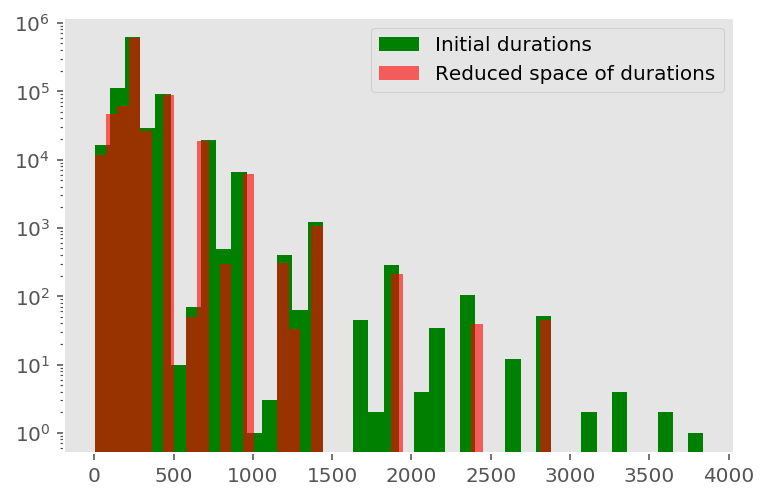

In [19]:
fig_durations = plt.figure()
plt.hist(merged_durations, bins=40, log=True, color='g', label='Initial durations')
plt.hist(reduce(lambda x, y: x + y, [cleaned_ds[x]['T'] for x in cleaned_ds]), 
         bins=40, log=True, color='r', alpha=0.6, label='Reduced space of durations')
plt.legend()
plt.show()

In [20]:
for label in np.random.choice(list(cleaned_ds.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('\n')

sessiontune6720
MIDI events
chorpus/sessiontune6720.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 64 	 Note On 	 105
240 	 64 	 Note Off 	 0
241 	 65 	 Note On 	 80
480 	 65 	 Note Off 	 0
481 	 67 	 Note On 	 105
720 	 67 	 Note Off 	 0
721 	 72 	 Note On 	 80
960 	 72 	 Note Off 	 0
961 	 69 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
52801 	 64 	 Note On 	 80
52960 	 64 	 Note Off 	 0
52961 	 67 	 Note On 	 80
53120 	 67 	 Note Off 	 0
53121 	 64 	 Note On 	 80
53280 	 64 	 Note Off 	 0
53281 	 60 	 Note On 	 95
53760 	 60 	 Note Off 	 0
########################################

Note representation
{'T': [240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 160, 160, 160, 240, 240, 160, 160, 160, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 160, 160, 160, 240, 240, 160, 160, 160, 240, 240, 240, 240, 240, 240, 2

In [21]:
def transposeDataset(dataset):
    transposed_dataset = {}

    for label in log_progress(list(dataset.keys()), every=1):
        transposed_dataset[label] = {}
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
        
    return transposed_dataset

In [22]:
transposed_dataset = transposeDataset(cleaned_ds)

In [23]:
dataset, dictionary = translation(transposed_dataset)

In [24]:
pitches = reduce(lambda x, y: x + y, [cleaned_ds[x]['P'] for x in cleaned_ds])
transposed_pitches = reduce(lambda x, y: x + y, [dataset[x]['P'] for x in dataset])

** Reduction of Durations space**

In [25]:
print('Initial dimension of space of possible durations: ', len(set(merged_durations)))
print('Dimension of space of possible durations after rare event supression: ', len(dictionary['T']))
print('Durations reduced by {} elements'.format(len(set(merged_durations)) - len(dictionary['T'])))
print('Durations reduced by {}%'.format(round((len(set(merged_durations)) - len(dictionary['T']))*100/len(set(merged_durations)),2)))

Initial dimension of space of possible durations:  65
Dimension of space of possible durations after rare event supression:  24
Durations reduced by 41 elements
Durations reduced by 63.08%


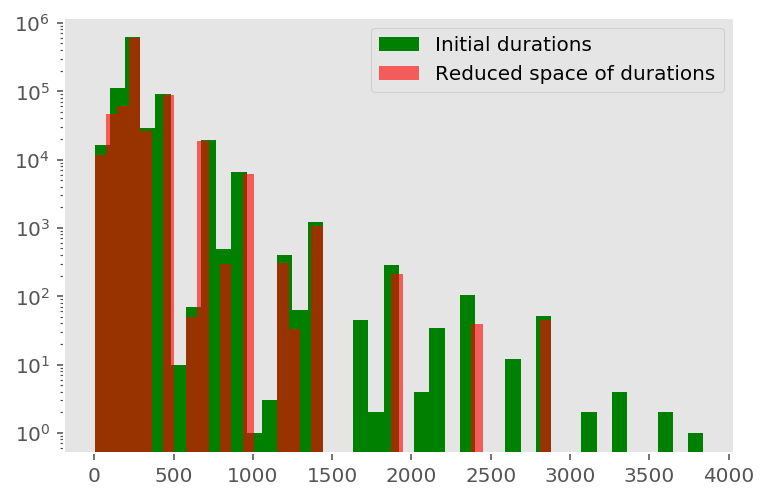

In [26]:
fig_durations

** Transposition of Pitches**

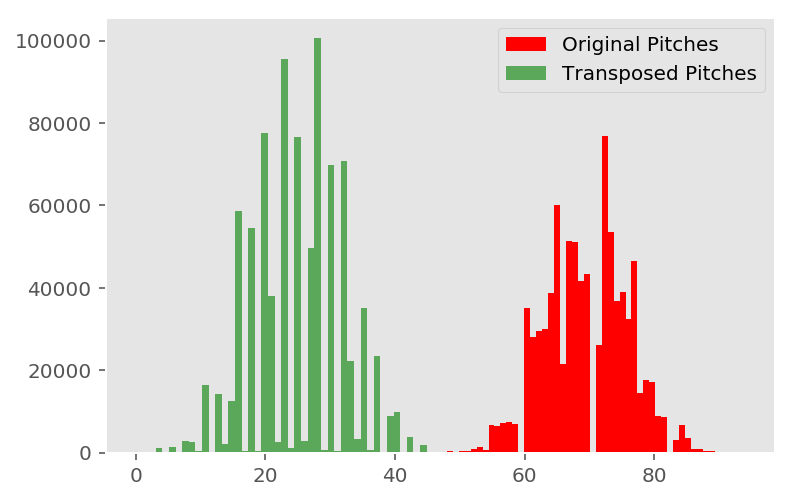

In [27]:
fig_transposed = plt.figure()
plt.hist(pitches, bins=50, color='r', label='Original Pitches')
plt.hist(transposed_pitches, bins=50, color='g', alpha=0.6, label='Transposed Pitches')
plt.legend()
plt.show()

In [28]:
print('Original dimension of pitches space:', len(set(pitches)))
print('Dimension of pitches space after transposition:', len(dictionary['P']))

Original dimension of pitches space: 47
Dimension of pitches space after transposition: 52


**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?
    
**Answer**: The space of possible durations has been reduced from 71 dimensions to 26. It means, a **63% reduction of the space dimension**. This reduction is proportionally translated to the training time.  

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**: In the case of transposing to a single tonality, it is equivalent to normalising the data an therefore treat the data independently of their "offset" but just taking into account pitch variations. If transposing to multiple tonalities, we are reproducing the same sequence relations along the different tonalities so the network will iddentify these same patterns in different "points" of the pitches dimension yielding to an independence of the tonality. 

**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint representation of a note duration and pitch (vs separating the two features)? 

**Answer**: If we had kept the original joint representation, the dimension of the input space would have been of (47)x(71) = **3337**. By spliting the representation into pitches and durations and performing reduction for durations and trasnposition for pitches, the final input dimension is of (26)+(52) = **78**. The dimension of the input is less than 2.5% of the one that would have been obtained with the original joint representation. 

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: The distribution would have been much sparse (less ocurrencies per possible combination) and wider (greater amount of possibilities). When spliting the representations and reducing the dimensions we obtain a more compact (less sparse) distribution as each dimension in represented sepparately and the relation pitch-duration is not taking part in the distribution of values per each dimension.

## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

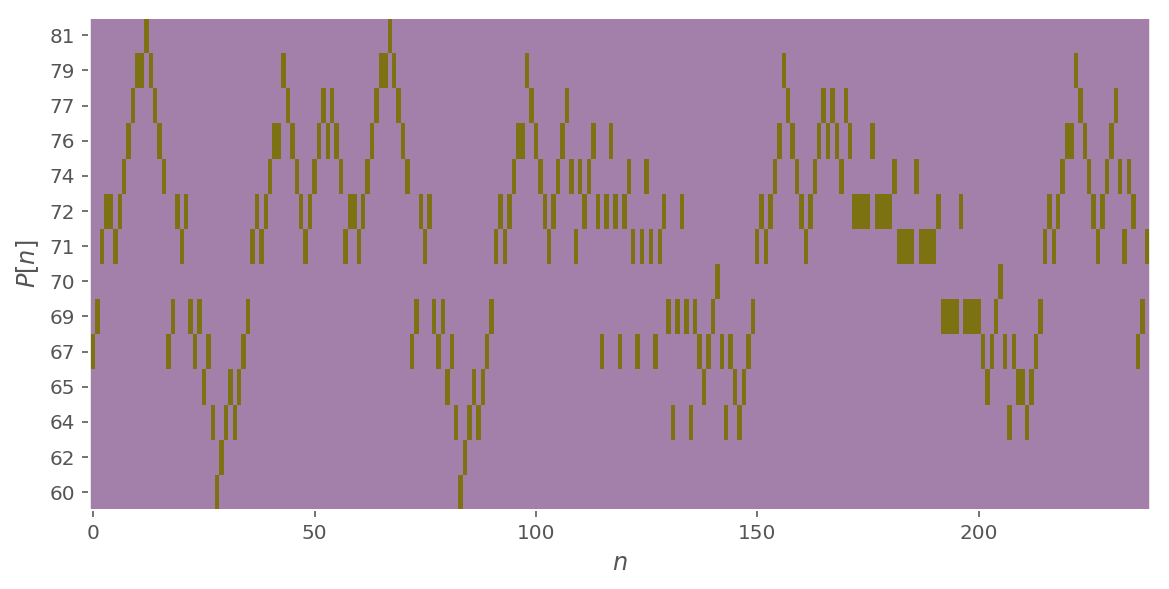

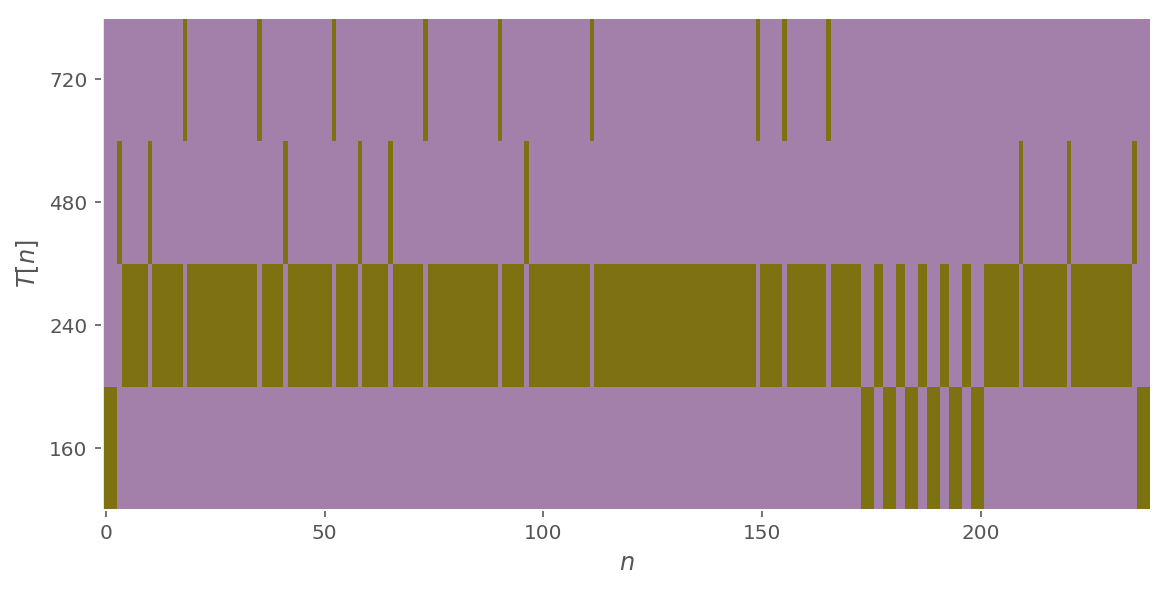

In [29]:
one_hot = {
    k: {
        'P': np_utils.to_categorical(dataset[k]['P'], len(dictionary['P'])),
        'T': np_utils.to_categorical(dataset[k]['T'], len(dictionary['T']))
    } for k in dataset.keys()
}
for label in np.random.choice(list(dataset.keys()), 1):
    plotMelody_joint(dataset[label]['P'], dataset[label]['T'], one_hot[label]['P'], one_hot[label]['T'], dictionary)

In [30]:
lengths = np.array([x['P'].shape[0] for k, x in one_hot.items()])

# max length
ml = int(lengths.mean() + 2 * lengths.std())

ps = pad_sequences([x['P'] for k, x in one_hot.items()], maxlen=ml, padding='post', truncating='post')
ts = pad_sequences([x['T'] for k, x in one_hot.items()], maxlen=ml, padding='post', truncating='post')

dataset_old = copy.deepcopy(dataset)

dataset = {}
for i, label in enumerate(list(one_hot.keys())):
    dataset[label] = {}
    dataset[label]['P'] = ps[i]
    dataset[label]['T'] = ts[i]

In [31]:
print('Number of songs:', len(dataset.keys()))
print('Number of notes:', ml)
print('Number of entries in the pitch dictionary', len(dictionary['P']))
print('Number of entries in the duration dictionary', len(dictionary['T']))
for label in np.random.choice(list(dataset.keys()), 1):
    print('Dimension of sequence of pitches:',(dataset[label]['P']).shape)
    print('Dimension of sequence of durations:',(dataset[label]['T']).shape)

Number of songs: 4510
Number of notes: 394
Number of entries in the pitch dictionary 52
Number of entries in the duration dictionary 24
Dimension of sequence of pitches: (394, 52)
Dimension of sequence of durations: (394, 24)


Melody: sessiontune9391
Before one-hot/zero-pad representation: 



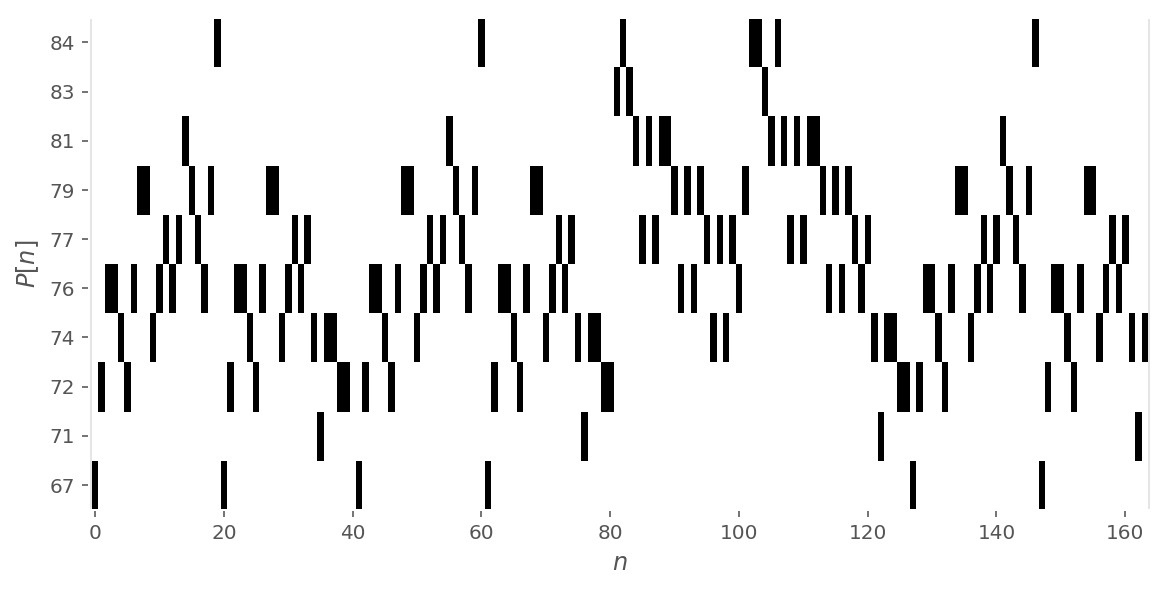

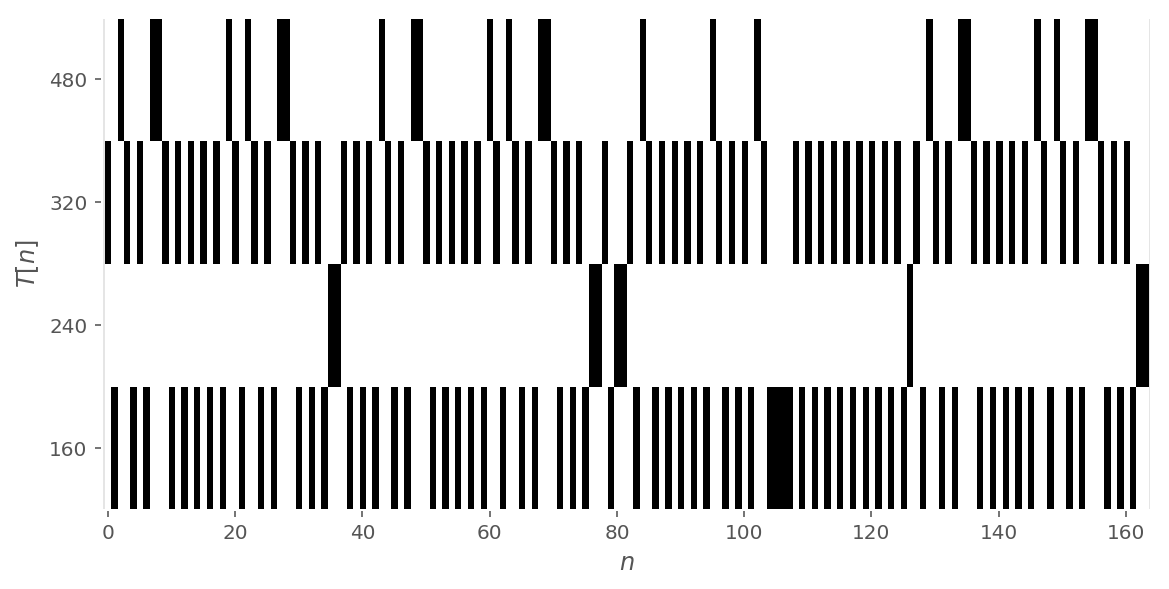

After one-hot/zero-pad representation: 



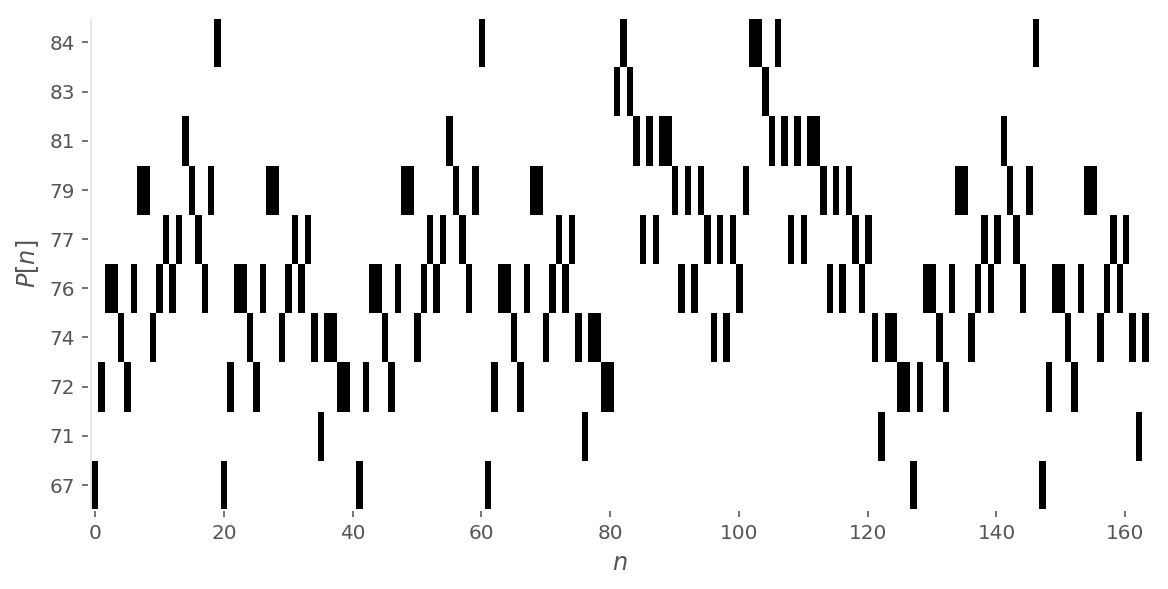

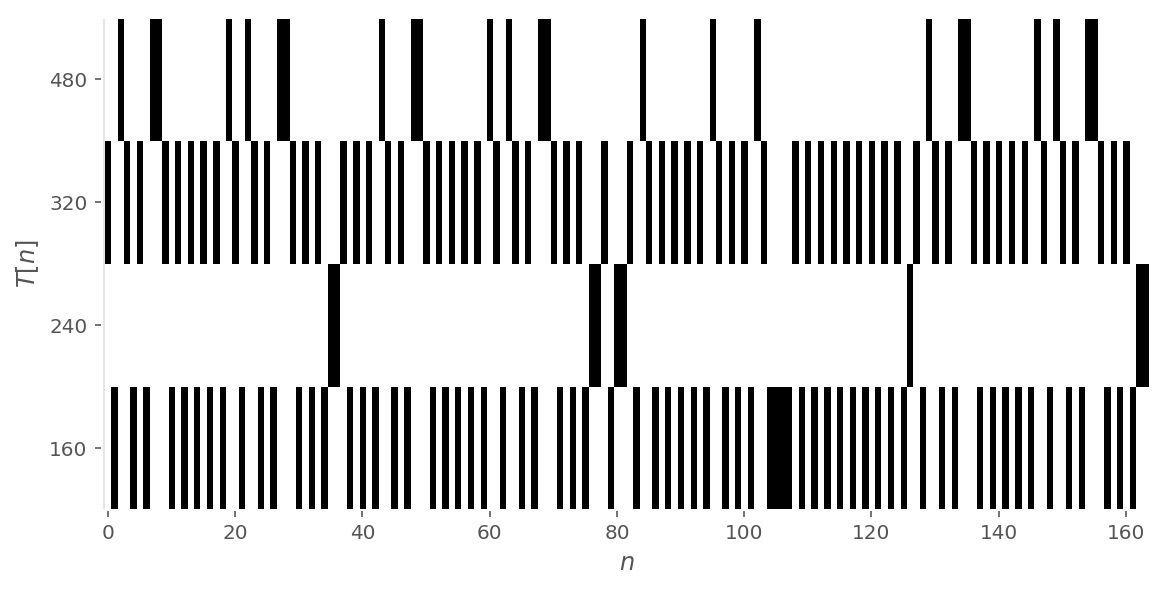

In [32]:
for label in np.random.choice(list(dataset.keys()), 1):
    print('Melody:' , label)
    print('Before one-hot/zero-pad representation: \n')
    plotMelody(dataset_old[label]['P'], dataset_old[label]['T'], dictionary)
    print('After one-hot/zero-pad representation: \n')
    plotMelody(dataset[label]['P'], dataset[label]['T'], dictionary)

In [33]:
# Saving variables to disk
save_var(dataset, "dataset")
save_var(dictionary, "dictionary")
save_var(ml, "ml")

In [34]:
# Loading variables from disk
dataset = load_var("dataset")
dictionary = load_var("dictionary")
ml = load_var("ml")

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

In [35]:
def buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128, improved=False):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    
    # If flag is true, using a more complex model
    if improved:
        if activation == 'GRU':
            H['2'] = GRU(units=Hsize*2, return_sequences=True, dropout=dropout)(H['1'])
            H['3'] = GRU(units=Hsize, return_sequences=True, dropout=dropout)(H['2'])
        elif activation == 'LSTM':
            pass
        elif activation == 'RNN':
            H['2'] = SimpleRNN(units=Hsize*2, return_sequences=True, dropout=dropout)(H['1'])
            H['3'] = SimpleRNN(units=Hsize, return_sequences=True, dropout=dropout)(H['2'])
        Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(H['3'])
        Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(H['3'])
        
    else:
        if activation == 'GRU':
            H['2'] = GRU(units=150, return_sequences=True, dropout=dropout)(H['1'])
            
        else:
            H['2'] = SimpleRNN(units=150, return_sequences=True, dropout=dropout)(H['1'])
            
        Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(H['2'])
        Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(H['2'])
    
    model = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P']])
    opt = Adam() 
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=opt,
        metrics=['acc'])
    
    return model

In [36]:
GRUmodel = buildModel(dictionary, batch_length=ml-1, activation='GRU')
GRUmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 393, 24)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 393, 52)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 393, 24)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 393, 52)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

In [37]:
RNNmodel = buildModel(dictionary, batch_length=ml-1, activation='RNN')
RNNmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 393, 24)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 393, 52)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 393, 24)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 393, 52)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

In [38]:
xs = {
    'XT': np.asarray([v['T'][:-1] for k, v in dataset.items()]), 
    'XP': np.asarray([v['P'][:-1] for k, v in dataset.items()])
}

ys = {
    'YT': np.asarray([v['T'][1:] for k, v in dataset.items()]), 
    'YP': np.asarray([v['P'][1:] for k, v in dataset.items()])
}

In [39]:
historyGRU = GRUmodel.fit(x=xs, y=ys, batch_size=ml-1, epochs=300, verbose=1, callbacks=None, validation_split=0.2)

Train on 3608 samples, validate on 902 samples
Epoch 1/300
3608/3608 [==============================] - 51s 14ms/step - loss: 6.7268 - YT_loss: 2.8476 - YP_loss: 3.8792 - YT_acc: 0.5153 - YP_acc: 0.0499 - val_loss: 5.9855 - val_YT_loss: 2.2368 - val_YP_loss: 3.7486 - val_YT_acc: 0.7141 - val_YP_acc: 0.0684
Epoch 2/300
3608/3608 [==============================] - 47s 13ms/step - loss: 5.2154 - YT_loss: 1.7582 - YP_loss: 3.4572 - YT_acc: 0.6927 - YP_acc: 0.0691 - val_loss: 4.3501 - val_YT_loss: 1.3292 - val_YP_loss: 3.0208 - val_YT_acc: 0.7140 - val_YP_acc: 0.1177
Epoch 3/300
3608/3608 [==============================] - 41s 11ms/step - loss: 4.2722 - YT_loss: 1.2523 - YP_loss: 3.0199 - YT_acc: 0.6930 - YP_acc: 0.1215 - val_loss: 3.8827 - val_YT_loss: 1.0379 - val_YP_loss: 2.8448 - val_YT_acc: 0.7142 - val_YP_acc: 0.1161
Epoch 4/300
3608/3608 [==============================] - 40s 11ms/step - loss: 3.9438 - YT_loss: 1.1161 - YP_loss: 2.8276 - YT_acc: 0.6936 - YP_acc: 0.1378 - val_loss: 3.

3608/3608 [==============================] - 40s 11ms/step - loss: 2.7399 - YT_loss: 0.7388 - YP_loss: 2.0010 - YT_acc: 0.7800 - YP_acc: 0.2971 - val_loss: 2.6318 - val_YT_loss: 0.6813 - val_YP_loss: 1.9505 - val_YT_acc: 0.7910 - val_YP_acc: 0.3150
Epoch 33/300
3608/3608 [==============================] - 41s 11ms/step - loss: 2.7329 - YT_loss: 0.7350 - YP_loss: 1.9979 - YT_acc: 0.7798 - YP_acc: 0.2991 - val_loss: 2.6219 - val_YT_loss: 0.6777 - val_YP_loss: 1.9442 - val_YT_acc: 0.7916 - val_YP_acc: 0.3153
Epoch 34/300
3608/3608 [==============================] - 40s 11ms/step - loss: 2.7262 - YT_loss: 0.7347 - YP_loss: 1.9915 - YT_acc: 0.7798 - YP_acc: 0.2999 - val_loss: 2.6126 - val_YT_loss: 0.6740 - val_YP_loss: 1.9386 - val_YT_acc: 0.7937 - val_YP_acc: 0.3188
Epoch 35/300
3608/3608 [==============================] - 40s 11ms/step - loss: 2.7143 - YT_loss: 0.7261 - YP_loss: 1.9882 - YT_acc: 0.7826 - YP_acc: 0.3014 - val_loss: 2.6053 - val_YT_loss: 0.6712 - val_YP_loss: 1.9341 - val_Y

3608/3608 [==============================] - 40s 11ms/step - loss: 2.5722 - YT_loss: 0.6686 - YP_loss: 1.9036 - YT_acc: 0.7972 - YP_acc: 0.3355 - val_loss: 2.4722 - val_YT_loss: 0.6232 - val_YP_loss: 1.8490 - val_YT_acc: 0.8111 - val_YP_acc: 0.3524
Epoch 64/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.5693 - YT_loss: 0.6680 - YP_loss: 1.9013 - YT_acc: 0.7979 - YP_acc: 0.3351 - val_loss: 2.4723 - val_YT_loss: 0.6249 - val_YP_loss: 1.8475 - val_YT_acc: 0.8106 - val_YP_acc: 0.3519
Epoch 65/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.5685 - YT_loss: 0.6692 - YP_loss: 1.8993 - YT_acc: 0.7970 - YP_acc: 0.3362 - val_loss: 2.4703 - val_YT_loss: 0.6230 - val_YP_loss: 1.8474 - val_YT_acc: 0.8112 - val_YP_acc: 0.3507
Epoch 66/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.5621 - YT_loss: 0.6643 - YP_loss: 1.8978 - YT_acc: 0.7994 - YP_acc: 0.3369 - val_loss: 2.4645 - val_YT_loss: 0.6197 - val_YP_loss: 1.8448 - val_Y

3608/3608 [==============================] - 39s 11ms/step - loss: 2.4827 - YT_loss: 0.6332 - YP_loss: 1.8495 - YT_acc: 0.8067 - YP_acc: 0.3532 - val_loss: 2.3940 - val_YT_loss: 0.5938 - val_YP_loss: 1.8002 - val_YT_acc: 0.8171 - val_YP_acc: 0.3673
Epoch 95/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.4808 - YT_loss: 0.6322 - YP_loss: 1.8486 - YT_acc: 0.8064 - YP_acc: 0.3540 - val_loss: 2.3902 - val_YT_loss: 0.5926 - val_YP_loss: 1.7976 - val_YT_acc: 0.8182 - val_YP_acc: 0.3682
Epoch 96/300
3608/3608 [==============================] - 40s 11ms/step - loss: 2.4726 - YT_loss: 0.6287 - YP_loss: 1.8439 - YT_acc: 0.8071 - YP_acc: 0.3557 - val_loss: 2.3879 - val_YT_loss: 0.5919 - val_YP_loss: 1.7960 - val_YT_acc: 0.8178 - val_YP_acc: 0.3703
Epoch 97/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.4715 - YT_loss: 0.6290 - YP_loss: 1.8425 - YT_acc: 0.8064 - YP_acc: 0.3558 - val_loss: 2.3862 - val_YT_loss: 0.5919 - val_YP_loss: 1.7942 - val_Y

3608/3608 [==============================] - 39s 11ms/step - loss: 2.4119 - YT_loss: 0.6079 - YP_loss: 1.8040 - YT_acc: 0.8110 - YP_acc: 0.3687 - val_loss: 2.3280 - val_YT_loss: 0.5698 - val_YP_loss: 1.7582 - val_YT_acc: 0.8207 - val_YP_acc: 0.3829
Epoch 126/300
3608/3608 [==============================] - 40s 11ms/step - loss: 2.4084 - YT_loss: 0.6051 - YP_loss: 1.8033 - YT_acc: 0.8104 - YP_acc: 0.3705 - val_loss: 2.3252 - val_YT_loss: 0.5687 - val_YP_loss: 1.7565 - val_YT_acc: 0.8214 - val_YP_acc: 0.3837
Epoch 127/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.4087 - YT_loss: 0.6071 - YP_loss: 1.8015 - YT_acc: 0.8106 - YP_acc: 0.3712 - val_loss: 2.3239 - val_YT_loss: 0.5683 - val_YP_loss: 1.7556 - val_YT_acc: 0.8215 - val_YP_acc: 0.3831
Epoch 128/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.4036 - YT_loss: 0.6051 - YP_loss: 1.7985 - YT_acc: 0.8098 - YP_acc: 0.3701 - val_loss: 2.3216 - val_YT_loss: 0.5680 - val_YP_loss: 1.7536 - va

3608/3608 [==============================] - 39s 11ms/step - loss: 2.3451 - YT_loss: 0.5798 - YP_loss: 1.7654 - YT_acc: 0.8153 - YP_acc: 0.3830 - val_loss: 2.2675 - val_YT_loss: 0.5458 - val_YP_loss: 1.7217 - val_YT_acc: 0.8251 - val_YP_acc: 0.3965
Epoch 157/300
3608/3608 [==============================] - 40s 11ms/step - loss: 2.3422 - YT_loss: 0.5803 - YP_loss: 1.7618 - YT_acc: 0.8151 - YP_acc: 0.3833 - val_loss: 2.2664 - val_YT_loss: 0.5454 - val_YP_loss: 1.7210 - val_YT_acc: 0.8252 - val_YP_acc: 0.3971
Epoch 158/300
3608/3608 [==============================] - 40s 11ms/step - loss: 2.3446 - YT_loss: 0.5811 - YP_loss: 1.7635 - YT_acc: 0.8150 - YP_acc: 0.3845 - val_loss: 2.2679 - val_YT_loss: 0.5454 - val_YP_loss: 1.7224 - val_YT_acc: 0.8248 - val_YP_acc: 0.3951
Epoch 159/300
3608/3608 [==============================] - 41s 11ms/step - loss: 2.3425 - YT_loss: 0.5797 - YP_loss: 1.7628 - YT_acc: 0.8153 - YP_acc: 0.3835 - val_loss: 2.2671 - val_YT_loss: 0.5432 - val_YP_loss: 1.7239 - va

3608/3608 [==============================] - 39s 11ms/step - loss: 2.2932 - YT_loss: 0.5602 - YP_loss: 1.7330 - YT_acc: 0.8187 - YP_acc: 0.3950 - val_loss: 2.2173 - val_YT_loss: 0.5240 - val_YP_loss: 1.6932 - val_YT_acc: 0.8295 - val_YP_acc: 0.4069
Epoch 188/300
3608/3608 [==============================] - 40s 11ms/step - loss: 2.2913 - YT_loss: 0.5587 - YP_loss: 1.7326 - YT_acc: 0.8197 - YP_acc: 0.3949 - val_loss: 2.2141 - val_YT_loss: 0.5221 - val_YP_loss: 1.6920 - val_YT_acc: 0.8291 - val_YP_acc: 0.4077
Epoch 189/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.2897 - YT_loss: 0.5575 - YP_loss: 1.7322 - YT_acc: 0.8187 - YP_acc: 0.3937 - val_loss: 2.2123 - val_YT_loss: 0.5216 - val_YP_loss: 1.6907 - val_YT_acc: 0.8294 - val_YP_acc: 0.4081
Epoch 190/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.2889 - YT_loss: 0.5588 - YP_loss: 1.7301 - YT_acc: 0.8191 - YP_acc: 0.3955 - val_loss: 2.2105 - val_YT_loss: 0.5210 - val_YP_loss: 1.6895 - va

3608/3608 [==============================] - 41s 11ms/step - loss: 2.2455 - YT_loss: 0.5415 - YP_loss: 1.7040 - YT_acc: 0.8217 - YP_acc: 0.4051 - val_loss: 2.1693 - val_YT_loss: 0.5052 - val_YP_loss: 1.6641 - val_YT_acc: 0.8321 - val_YP_acc: 0.4170
Epoch 219/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.2431 - YT_loss: 0.5403 - YP_loss: 1.7028 - YT_acc: 0.8212 - YP_acc: 0.4052 - val_loss: 2.1680 - val_YT_loss: 0.5040 - val_YP_loss: 1.6640 - val_YT_acc: 0.8318 - val_YP_acc: 0.4175
Epoch 220/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.2384 - YT_loss: 0.5387 - YP_loss: 1.6997 - YT_acc: 0.8222 - YP_acc: 0.4051 - val_loss: 2.1676 - val_YT_loss: 0.5046 - val_YP_loss: 1.6630 - val_YT_acc: 0.8325 - val_YP_acc: 0.4180
Epoch 221/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.2409 - YT_loss: 0.5393 - YP_loss: 1.7016 - YT_acc: 0.8218 - YP_acc: 0.4047 - val_loss: 2.1656 - val_YT_loss: 0.5036 - val_YP_loss: 1.6620 - va

3608/3608 [==============================] - 39s 11ms/step - loss: 2.2081 - YT_loss: 0.5312 - YP_loss: 1.6769 - YT_acc: 0.8231 - YP_acc: 0.4133 - val_loss: 2.1389 - val_YT_loss: 0.4946 - val_YP_loss: 1.6443 - val_YT_acc: 0.8332 - val_YP_acc: 0.4245
Epoch 250/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.2039 - YT_loss: 0.5274 - YP_loss: 1.6765 - YT_acc: 0.8238 - YP_acc: 0.4134 - val_loss: 2.1617 - val_YT_loss: 0.5100 - val_YP_loss: 1.6517 - val_YT_acc: 0.8328 - val_YP_acc: 0.4203
Epoch 251/300
3608/3608 [==============================] - 40s 11ms/step - loss: 2.2299 - YT_loss: 0.5433 - YP_loss: 1.6866 - YT_acc: 0.8225 - YP_acc: 0.4087 - val_loss: 2.1497 - val_YT_loss: 0.5041 - val_YP_loss: 1.6456 - val_YT_acc: 0.8309 - val_YP_acc: 0.4230
Epoch 252/300
3608/3608 [==============================] - 40s 11ms/step - loss: 2.2118 - YT_loss: 0.5327 - YP_loss: 1.6791 - YT_acc: 0.8239 - YP_acc: 0.4125 - val_loss: 2.1411 - val_YT_loss: 0.4984 - val_YP_loss: 1.6427 - va

3608/3608 [==============================] - 40s 11ms/step - loss: 2.1794 - YT_loss: 0.5231 - YP_loss: 1.6563 - YT_acc: 0.8252 - YP_acc: 0.4196 - val_loss: 2.1152 - val_YT_loss: 0.4906 - val_YP_loss: 1.6247 - val_YT_acc: 0.8342 - val_YP_acc: 0.4323
Epoch 281/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.1743 - YT_loss: 0.5198 - YP_loss: 1.6545 - YT_acc: 0.8247 - YP_acc: 0.4211 - val_loss: 2.1110 - val_YT_loss: 0.4895 - val_YP_loss: 1.6215 - val_YT_acc: 0.8337 - val_YP_acc: 0.4324
Epoch 282/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.1708 - YT_loss: 0.5179 - YP_loss: 1.6529 - YT_acc: 0.8252 - YP_acc: 0.4230 - val_loss: 2.1076 - val_YT_loss: 0.4873 - val_YP_loss: 1.6204 - val_YT_acc: 0.8343 - val_YP_acc: 0.4343
Epoch 283/300
3608/3608 [==============================] - 39s 11ms/step - loss: 2.1650 - YT_loss: 0.5174 - YP_loss: 1.6476 - YT_acc: 0.8255 - YP_acc: 0.4238 - val_loss: 2.1119 - val_YT_loss: 0.4918 - val_YP_loss: 1.6201 - va

In [40]:
historyRNN = RNNmodel.fit(x=xs, y=ys, batch_size=ml-1, epochs=300, verbose=1, callbacks=None, validation_split=0.2)

Train on 3608 samples, validate on 902 samples
Epoch 1/300
3608/3608 [==============================] - 27s 7ms/step - loss: 5.8289 - YT_loss: 2.1814 - YP_loss: 3.6476 - YT_acc: 0.4828 - YP_acc: 0.0488 - val_loss: 4.3535 - val_YT_loss: 1.2216 - val_YP_loss: 3.1319 - val_YT_acc: 0.7078 - val_YP_acc: 0.1098
Epoch 2/300
3608/3608 [==============================] - 26s 7ms/step - loss: 4.1967 - YT_loss: 1.2267 - YP_loss: 2.9700 - YT_acc: 0.6875 - YP_acc: 0.1199 - val_loss: 3.9467 - val_YT_loss: 1.0987 - val_YP_loss: 2.8481 - val_YT_acc: 0.7102 - val_YP_acc: 0.1136
Epoch 3/300
3608/3608 [==============================] - 26s 7ms/step - loss: 3.9900 - YT_loss: 1.1563 - YP_loss: 2.8337 - YT_acc: 0.6895 - YP_acc: 0.1156 - val_loss: 3.8845 - val_YT_loss: 1.0795 - val_YP_loss: 2.8051 - val_YT_acc: 0.7113 - val_YP_acc: 0.1164
Epoch 4/300
3608/3608 [==============================] - 27s 7ms/step - loss: 3.9201 - YT_loss: 1.1223 - YP_loss: 2.7978 - YT_acc: 0.6902 - YP_acc: 0.1326 - val_loss: 3.8028

3608/3608 [==============================] - 26s 7ms/step - loss: 2.8390 - YT_loss: 0.7962 - YP_loss: 2.0429 - YT_acc: 0.7690 - YP_acc: 0.2938 - val_loss: 2.6803 - val_YT_loss: 0.7048 - val_YP_loss: 1.9755 - val_YT_acc: 0.7900 - val_YP_acc: 0.3149
Epoch 33/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.8028 - YT_loss: 0.7674 - YP_loss: 2.0354 - YT_acc: 0.7767 - YP_acc: 0.2951 - val_loss: 2.6520 - val_YT_loss: 0.6845 - val_YP_loss: 1.9676 - val_YT_acc: 0.7915 - val_YP_acc: 0.3192
Epoch 34/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.7856 - YT_loss: 0.7600 - YP_loss: 2.0256 - YT_acc: 0.7765 - YP_acc: 0.2956 - val_loss: 2.6409 - val_YT_loss: 0.6809 - val_YP_loss: 1.9600 - val_YT_acc: 0.7922 - val_YP_acc: 0.3217
Epoch 35/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.7868 - YT_loss: 0.7651 - YP_loss: 2.0217 - YT_acc: 0.7770 - YP_acc: 0.2978 - val_loss: 2.6546 - val_YT_loss: 0.6845 - val_YP_loss: 1.9700 - val_YT_ac

3608/3608 [==============================] - 26s 7ms/step - loss: 2.6814 - YT_loss: 0.7206 - YP_loss: 1.9608 - YT_acc: 0.7888 - YP_acc: 0.3138 - val_loss: 2.5255 - val_YT_loss: 0.6494 - val_YP_loss: 1.8761 - val_YT_acc: 0.8050 - val_YP_acc: 0.3442
Epoch 64/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.6832 - YT_loss: 0.7272 - YP_loss: 1.9560 - YT_acc: 0.7882 - YP_acc: 0.3158 - val_loss: 2.5258 - val_YT_loss: 0.6481 - val_YP_loss: 1.8777 - val_YT_acc: 0.8080 - val_YP_acc: 0.3410
Epoch 65/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.6831 - YT_loss: 0.7258 - YP_loss: 1.9573 - YT_acc: 0.7883 - YP_acc: 0.3151 - val_loss: 2.5232 - val_YT_loss: 0.6475 - val_YP_loss: 1.8756 - val_YT_acc: 0.8061 - val_YP_acc: 0.3450
Epoch 66/300
3608/3608 [==============================] - 27s 7ms/step - loss: 2.6711 - YT_loss: 0.7191 - YP_loss: 1.9521 - YT_acc: 0.7903 - YP_acc: 0.3160 - val_loss: 2.5144 - val_YT_loss: 0.6465 - val_YP_loss: 1.8679 - val_YT_ac

3608/3608 [==============================] - 26s 7ms/step - loss: 2.6334 - YT_loss: 0.7030 - YP_loss: 1.9304 - YT_acc: 0.7931 - YP_acc: 0.3233 - val_loss: 2.4745 - val_YT_loss: 0.6327 - val_YP_loss: 1.8418 - val_YT_acc: 0.8101 - val_YP_acc: 0.3511
Epoch 95/300
3608/3608 [==============================] - 27s 8ms/step - loss: 2.6391 - YT_loss: 0.7123 - YP_loss: 1.9268 - YT_acc: 0.7922 - YP_acc: 0.3237 - val_loss: 2.4768 - val_YT_loss: 0.6330 - val_YP_loss: 1.8438 - val_YT_acc: 0.8106 - val_YP_acc: 0.3499
Epoch 96/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.6321 - YT_loss: 0.7047 - YP_loss: 1.9274 - YT_acc: 0.7936 - YP_acc: 0.3226 - val_loss: 2.4723 - val_YT_loss: 0.6327 - val_YP_loss: 1.8396 - val_YT_acc: 0.8103 - val_YP_acc: 0.3507
Epoch 97/300
3608/3608 [==============================] - 28s 8ms/step - loss: 2.6345 - YT_loss: 0.7091 - YP_loss: 1.9253 - YT_acc: 0.7917 - YP_acc: 0.3233 - val_loss: 2.4754 - val_YT_loss: 0.6329 - val_YP_loss: 1.8425 - val_YT_ac

3608/3608 [==============================] - 26s 7ms/step - loss: 2.6019 - YT_loss: 0.6926 - YP_loss: 1.9093 - YT_acc: 0.7948 - YP_acc: 0.3298 - val_loss: 2.4486 - val_YT_loss: 0.6234 - val_YP_loss: 1.8252 - val_YT_acc: 0.8116 - val_YP_acc: 0.3572
Epoch 126/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.6004 - YT_loss: 0.6916 - YP_loss: 1.9088 - YT_acc: 0.7954 - YP_acc: 0.3282 - val_loss: 2.4461 - val_YT_loss: 0.6243 - val_YP_loss: 1.8218 - val_YT_acc: 0.8130 - val_YP_acc: 0.3581
Epoch 127/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.6072 - YT_loss: 0.6996 - YP_loss: 1.9076 - YT_acc: 0.7936 - YP_acc: 0.3298 - val_loss: 2.4600 - val_YT_loss: 0.6242 - val_YP_loss: 1.8358 - val_YT_acc: 0.8125 - val_YP_acc: 0.3567
Epoch 128/300
3608/3608 [==============================] - 28s 8ms/step - loss: 2.6054 - YT_loss: 0.6922 - YP_loss: 1.9132 - YT_acc: 0.7947 - YP_acc: 0.3286 - val_loss: 2.4418 - val_YT_loss: 0.6225 - val_YP_loss: 1.8193 - val_YT

3608/3608 [==============================] - 26s 7ms/step - loss: 2.6023 - YT_loss: 0.6978 - YP_loss: 1.9045 - YT_acc: 0.7931 - YP_acc: 0.3319 - val_loss: 2.4376 - val_YT_loss: 0.6186 - val_YP_loss: 1.8190 - val_YT_acc: 0.8126 - val_YP_acc: 0.3578
Epoch 157/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.5847 - YT_loss: 0.6831 - YP_loss: 1.9016 - YT_acc: 0.7987 - YP_acc: 0.3312 - val_loss: 2.4290 - val_YT_loss: 0.6177 - val_YP_loss: 1.8113 - val_YT_acc: 0.8143 - val_YP_acc: 0.3612
Epoch 158/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.5911 - YT_loss: 0.6924 - YP_loss: 1.8986 - YT_acc: 0.7956 - YP_acc: 0.3329 - val_loss: 2.4332 - val_YT_loss: 0.6181 - val_YP_loss: 1.8151 - val_YT_acc: 0.8141 - val_YP_acc: 0.3596
Epoch 159/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.5861 - YT_loss: 0.6844 - YP_loss: 1.9017 - YT_acc: 0.7976 - YP_acc: 0.3315 - val_loss: 2.4223 - val_YT_loss: 0.6159 - val_YP_loss: 1.8065 - val_YT

3608/3608 [==============================] - 26s 7ms/step - loss: 2.5656 - YT_loss: 0.6783 - YP_loss: 1.8873 - YT_acc: 0.7963 - YP_acc: 0.3367 - val_loss: 2.4165 - val_YT_loss: 0.6086 - val_YP_loss: 1.8079 - val_YT_acc: 0.8154 - val_YP_acc: 0.3609
Epoch 188/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.5602 - YT_loss: 0.6717 - YP_loss: 1.8885 - YT_acc: 0.7993 - YP_acc: 0.3349 - val_loss: 2.4056 - val_YT_loss: 0.6053 - val_YP_loss: 1.8004 - val_YT_acc: 0.8157 - val_YP_acc: 0.3658
Epoch 189/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.5707 - YT_loss: 0.6857 - YP_loss: 1.8850 - YT_acc: 0.7956 - YP_acc: 0.3371 - val_loss: 2.4075 - val_YT_loss: 0.6061 - val_YP_loss: 1.8015 - val_YT_acc: 0.8150 - val_YP_acc: 0.3648
Epoch 190/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.5628 - YT_loss: 0.6789 - YP_loss: 1.8839 - YT_acc: 0.7973 - YP_acc: 0.3371 - val_loss: 2.4434 - val_YT_loss: 0.6298 - val_YP_loss: 1.8136 - val_YT

3608/3608 [==============================] - 26s 7ms/step - loss: 2.5459 - YT_loss: 0.6700 - YP_loss: 1.8758 - YT_acc: 0.7992 - YP_acc: 0.3403 - val_loss: 2.3943 - val_YT_loss: 0.5949 - val_YP_loss: 1.7995 - val_YT_acc: 0.8183 - val_YP_acc: 0.3653
Epoch 219/300
3608/3608 [==============================] - 25s 7ms/step - loss: 2.5434 - YT_loss: 0.6653 - YP_loss: 1.8781 - YT_acc: 0.7998 - YP_acc: 0.3399 - val_loss: 2.3851 - val_YT_loss: 0.5929 - val_YP_loss: 1.7922 - val_YT_acc: 0.8185 - val_YP_acc: 0.3711
Epoch 220/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.5376 - YT_loss: 0.6651 - YP_loss: 1.8726 - YT_acc: 0.8009 - YP_acc: 0.3415 - val_loss: 2.3880 - val_YT_loss: 0.5936 - val_YP_loss: 1.7944 - val_YT_acc: 0.8177 - val_YP_acc: 0.3665
Epoch 221/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.5457 - YT_loss: 0.6671 - YP_loss: 1.8786 - YT_acc: 0.7997 - YP_acc: 0.3402 - val_loss: 2.3975 - val_YT_loss: 0.5982 - val_YP_loss: 1.7993 - val_YT

3608/3608 [==============================] - 26s 7ms/step - loss: 2.5389 - YT_loss: 0.6635 - YP_loss: 1.8754 - YT_acc: 0.8017 - YP_acc: 0.3399 - val_loss: 2.3796 - val_YT_loss: 0.5879 - val_YP_loss: 1.7917 - val_YT_acc: 0.8208 - val_YP_acc: 0.3688
Epoch 250/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.5347 - YT_loss: 0.6617 - YP_loss: 1.8730 - YT_acc: 0.8012 - YP_acc: 0.3423 - val_loss: 2.3660 - val_YT_loss: 0.5844 - val_YP_loss: 1.7815 - val_YT_acc: 0.8219 - val_YP_acc: 0.3726
Epoch 251/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.5196 - YT_loss: 0.6513 - YP_loss: 1.8684 - YT_acc: 0.8028 - YP_acc: 0.3423 - val_loss: 2.3719 - val_YT_loss: 0.5844 - val_YP_loss: 1.7875 - val_YT_acc: 0.8198 - val_YP_acc: 0.3699
Epoch 252/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.5217 - YT_loss: 0.6536 - YP_loss: 1.8680 - YT_acc: 0.8013 - YP_acc: 0.3435 - val_loss: 2.3698 - val_YT_loss: 0.5821 - val_YP_loss: 1.7877 - val_YT

3608/3608 [==============================] - 27s 7ms/step - loss: 2.5284 - YT_loss: 0.6597 - YP_loss: 1.8688 - YT_acc: 0.8015 - YP_acc: 0.3431 - val_loss: 2.3669 - val_YT_loss: 0.5805 - val_YP_loss: 1.7864 - val_YT_acc: 0.8224 - val_YP_acc: 0.3731
Epoch 281/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.5172 - YT_loss: 0.6495 - YP_loss: 1.8677 - YT_acc: 0.8033 - YP_acc: 0.3429 - val_loss: 2.3581 - val_YT_loss: 0.5763 - val_YP_loss: 1.7818 - val_YT_acc: 0.8218 - val_YP_acc: 0.3747
Epoch 282/300
3608/3608 [==============================] - 27s 8ms/step - loss: 2.5237 - YT_loss: 0.6555 - YP_loss: 1.8682 - YT_acc: 0.8007 - YP_acc: 0.3441 - val_loss: 2.3588 - val_YT_loss: 0.5757 - val_YP_loss: 1.7831 - val_YT_acc: 0.8227 - val_YP_acc: 0.3752
Epoch 283/300
3608/3608 [==============================] - 26s 7ms/step - loss: 2.5160 - YT_loss: 0.6506 - YP_loss: 1.8654 - YT_acc: 0.8023 - YP_acc: 0.3448 - val_loss: 2.3541 - val_YT_loss: 0.5773 - val_YP_loss: 1.7768 - val_YT

<Figure size 432x288 with 0 Axes>

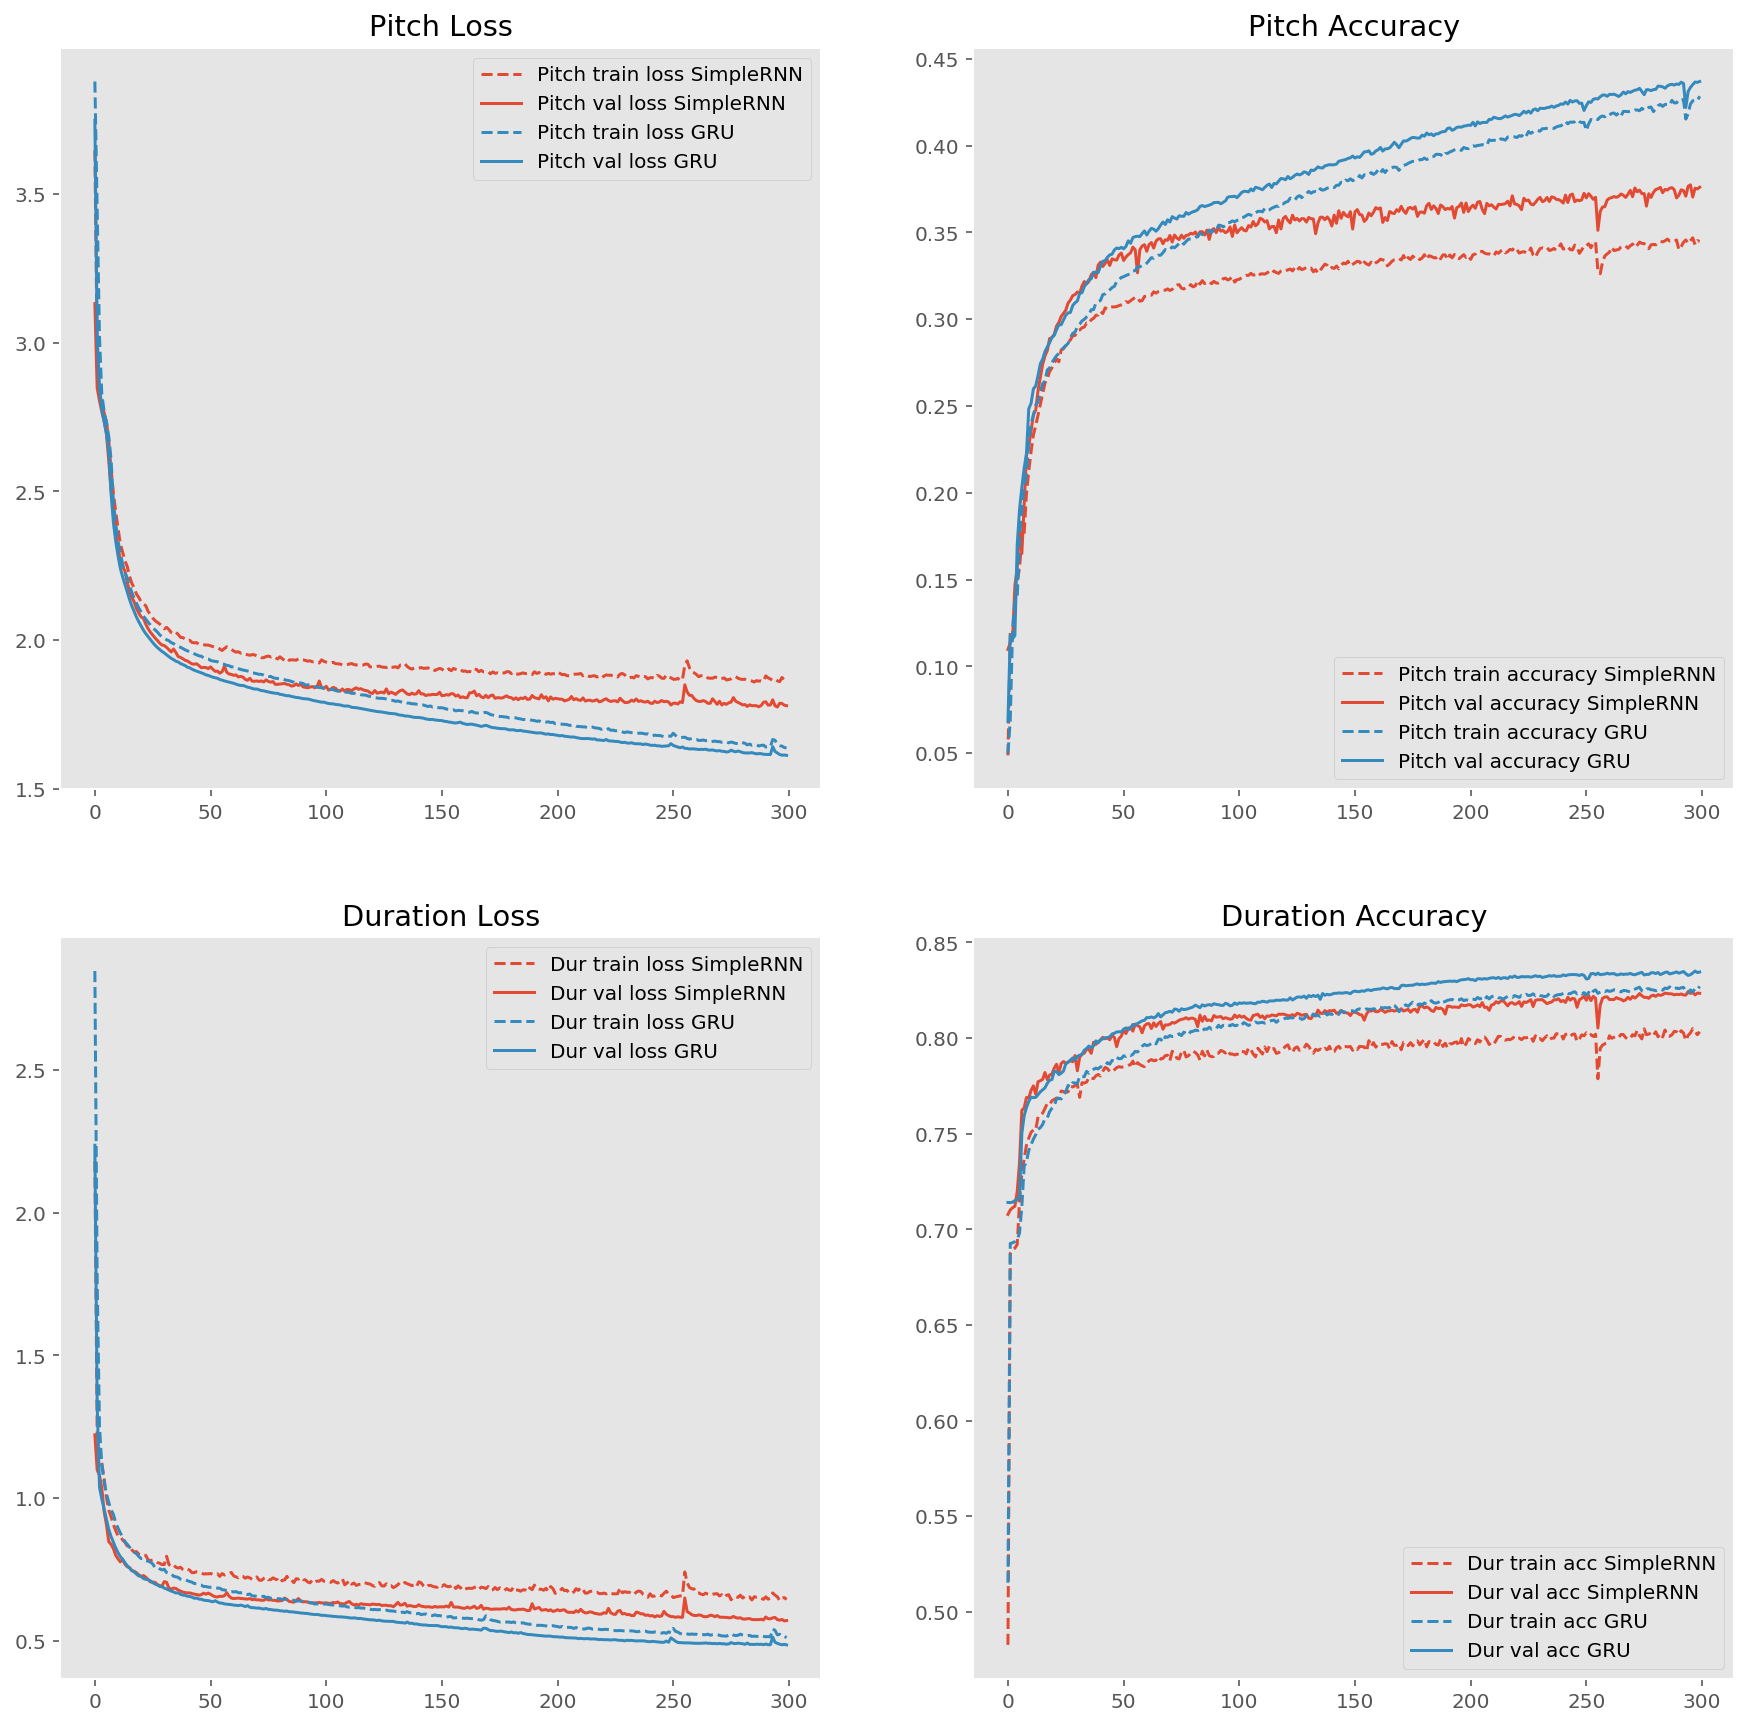

In [41]:
plotLearningCurves_separated(historyRNN, historyGRU)

In [42]:
save_model(RNNmodel, "RNNmodel")
save_model(GRUmodel, "GRUmodel")

**Question**: What are the best prediction accuracies you obtained? With which model?
    
**Answer**: The best predictions with networks with one hidden layer and 128 hidden units are obtained using GRU cells, which gives better overall accuracy in the test set (???????). In order to have a richer model, more complex models with better accuracy are explored for generating melodies in exercise 7. 

**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation function.
    
**Answer**: Given the learning curves of both activation funtions, it can be seen that GRU function provides better results as per accuracy and loss in both pitch and durations cases. In the case of vanilla RNN, the accuracy stops improving earlier as the gradient vanishes earlier due to less capability of keeping long-term relations compared to GRU units. 



## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

In [43]:
RNNmodel = load_model("RNNmodel")
GRUmodel = load_model("GRUmodel")

In [44]:
get_intermediate_RNN = K.function([RNNmodel.layers[0].input, RNNmodel.layers[1].input],
                              [RNNmodel.layers[5].output])

get_intermediate_GRU = K.function([GRUmodel.layers[0].input, GRUmodel.layers[1].input],
                              [GRUmodel.layers[5].output])

In [45]:
def get_accuracy(notes, dic):
    accu = 0
    real = 0
    for i, e in enumerate(notes):
        if 1 in dataset[label][dic][i]:
            real +=1
            real_one = np.where(dataset[label][dic][i] == 1)[0]
            one = np.argmax(e)

            if real_one == one: 
                accu += 1
    accu = round(accu/real,4)*100
    return accu

sessiontune17518 SimpleRNNmodel 



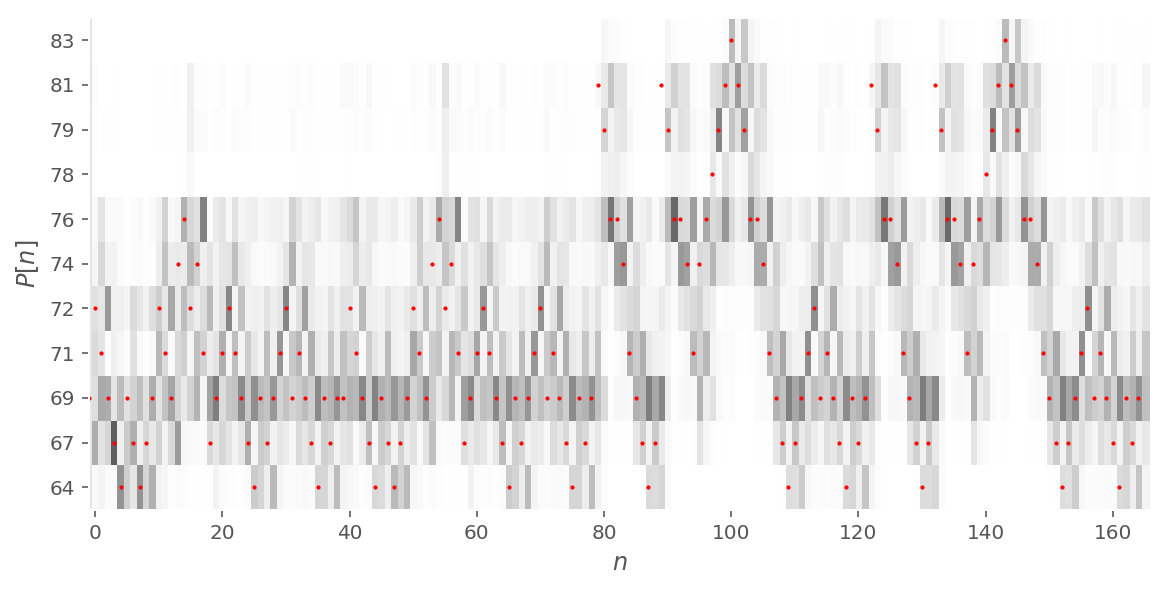

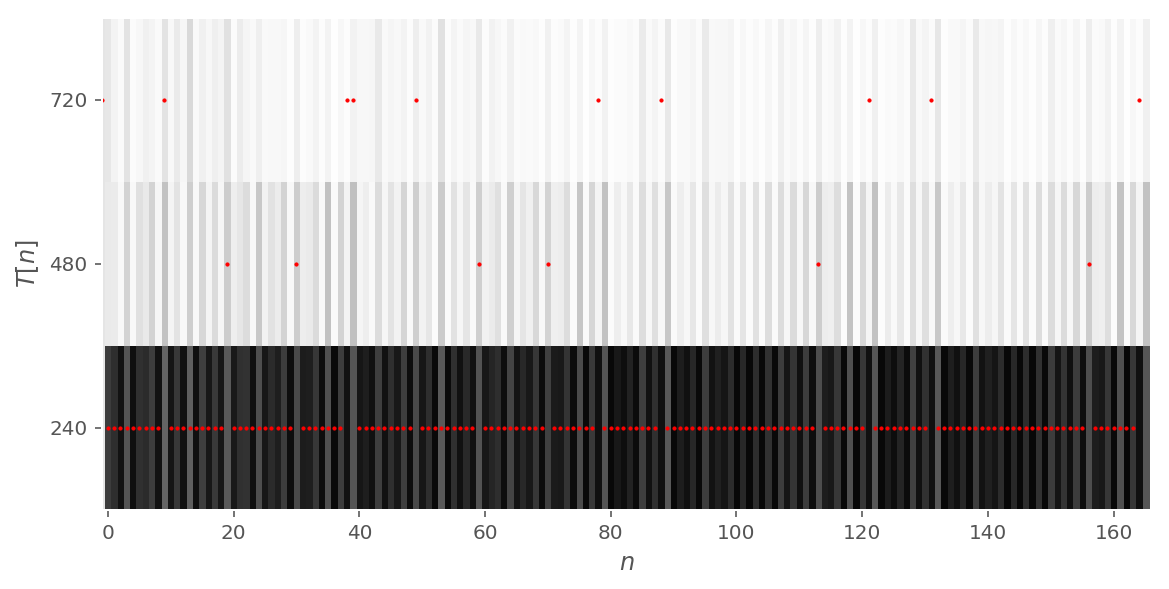

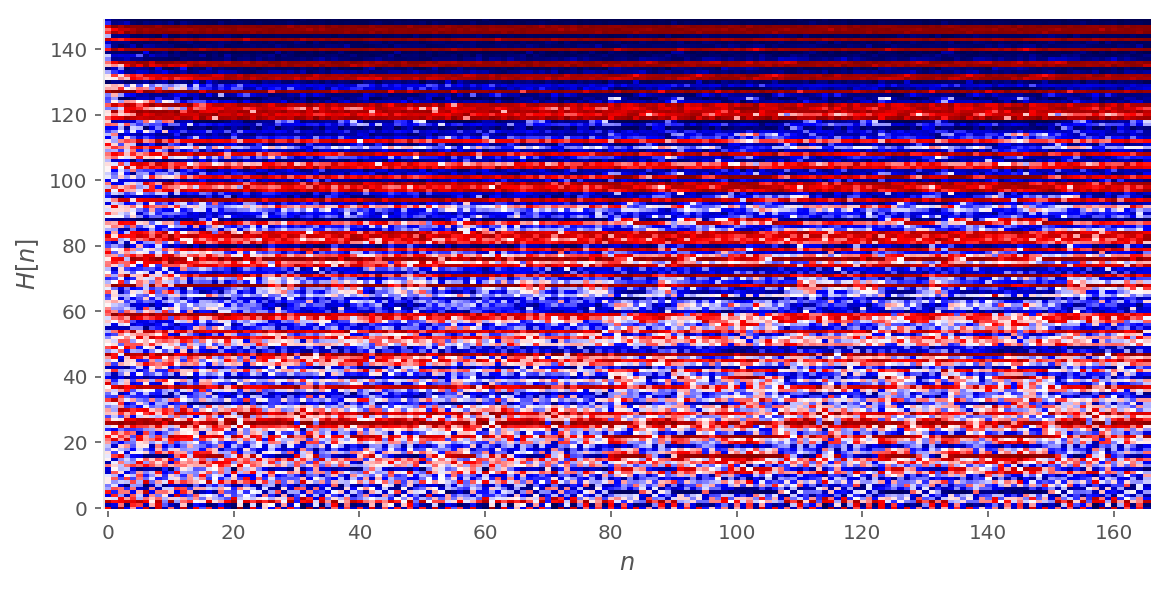

Accuracy: 'P': 6.02%, 'T': 90.36% 

sessiontune17518 GRUmodel 



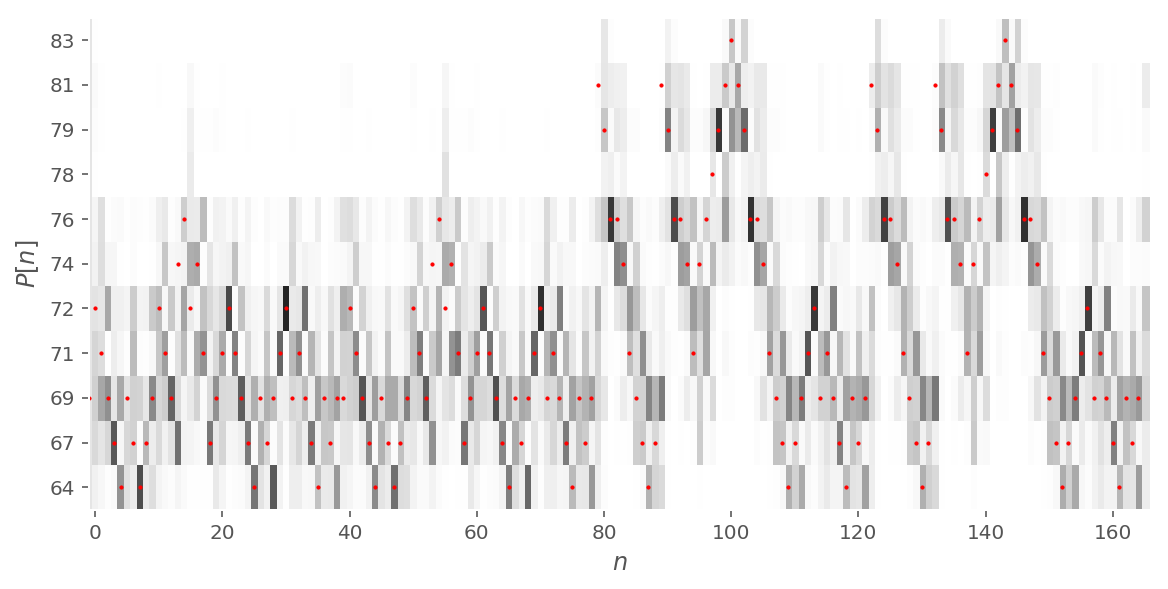

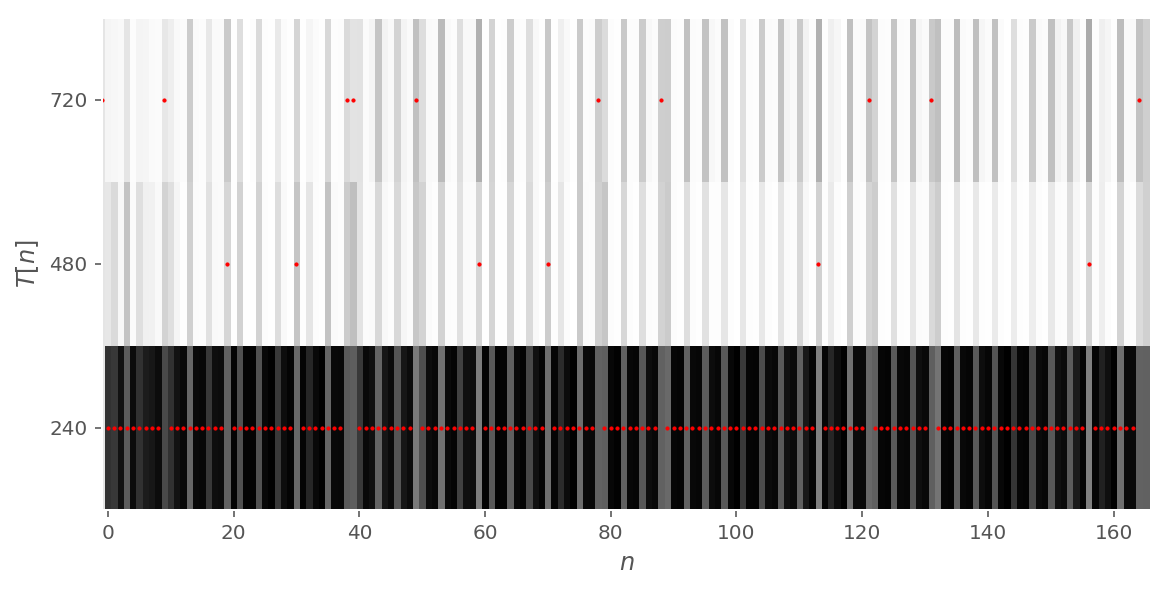

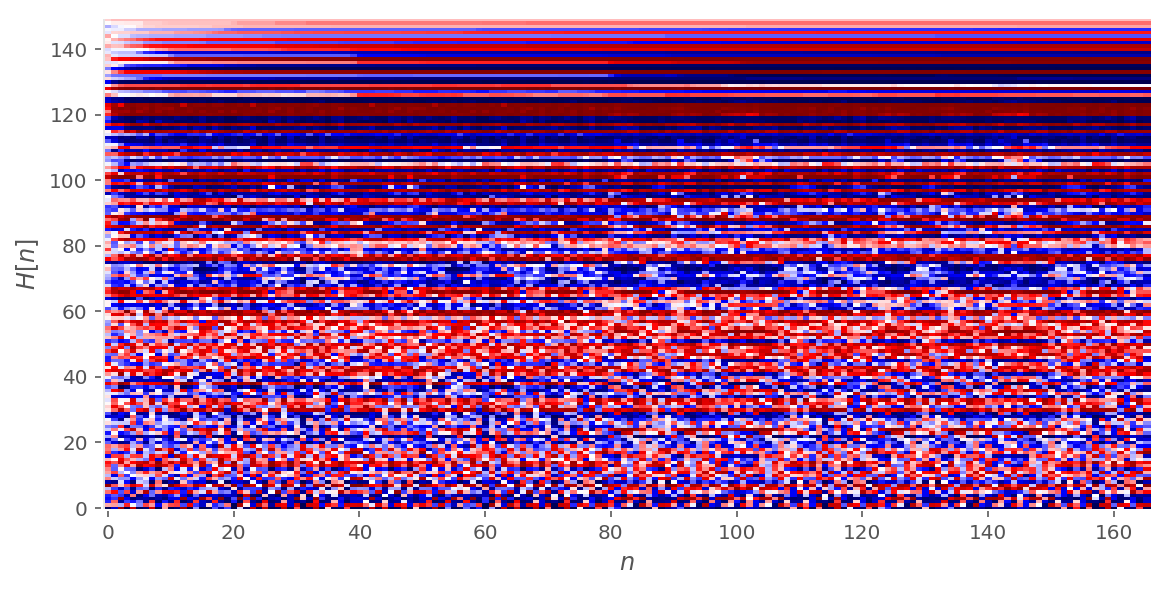

Accuracy: 'P': 4.82%, 'T': 90.36% 

sessiontune22708 SimpleRNNmodel 



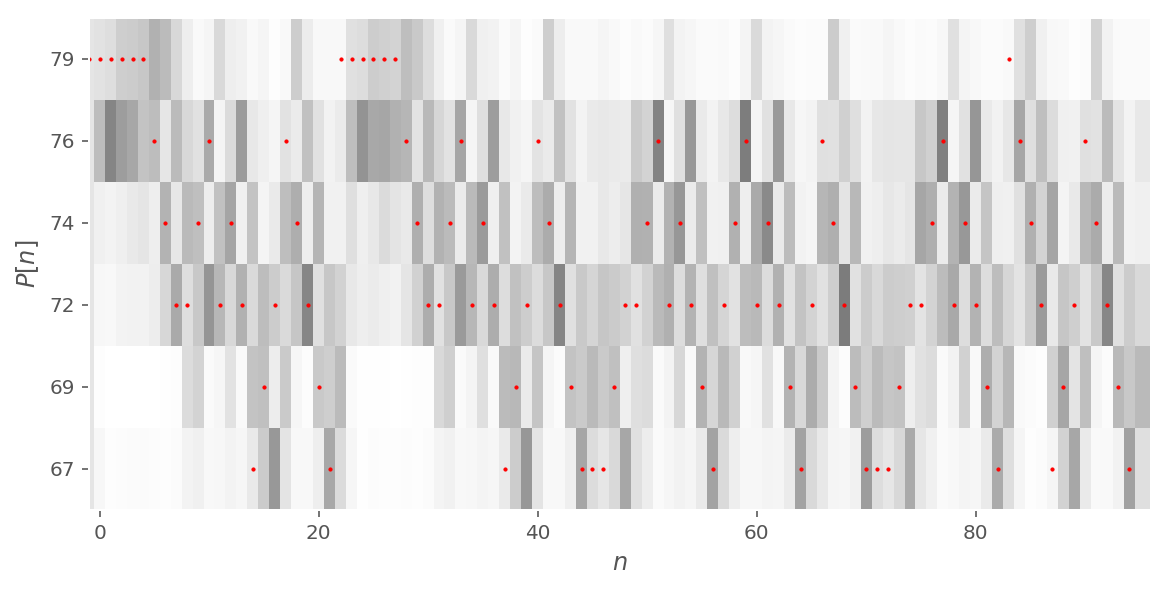

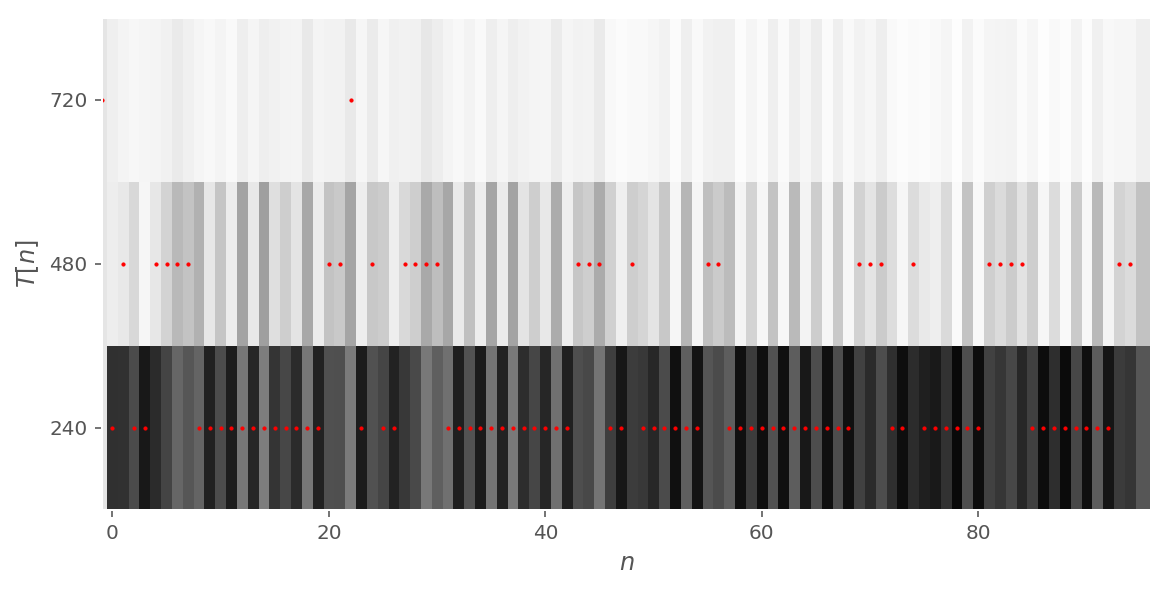

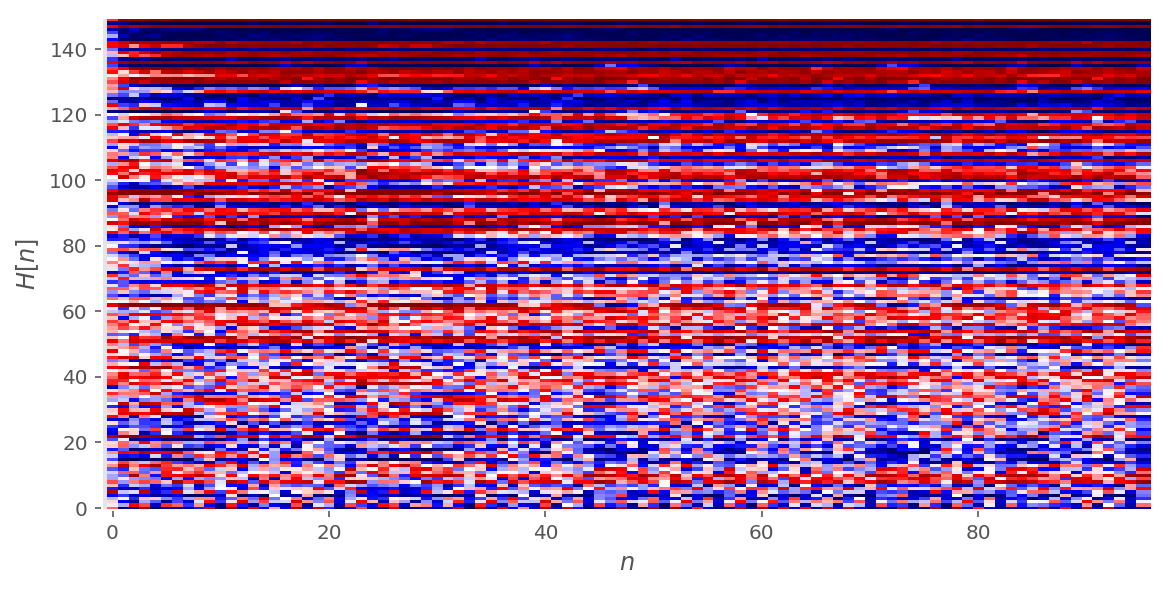

Accuracy: 'P': 1.04%, 'T': 68.75% 

sessiontune22708 GRUmodel 



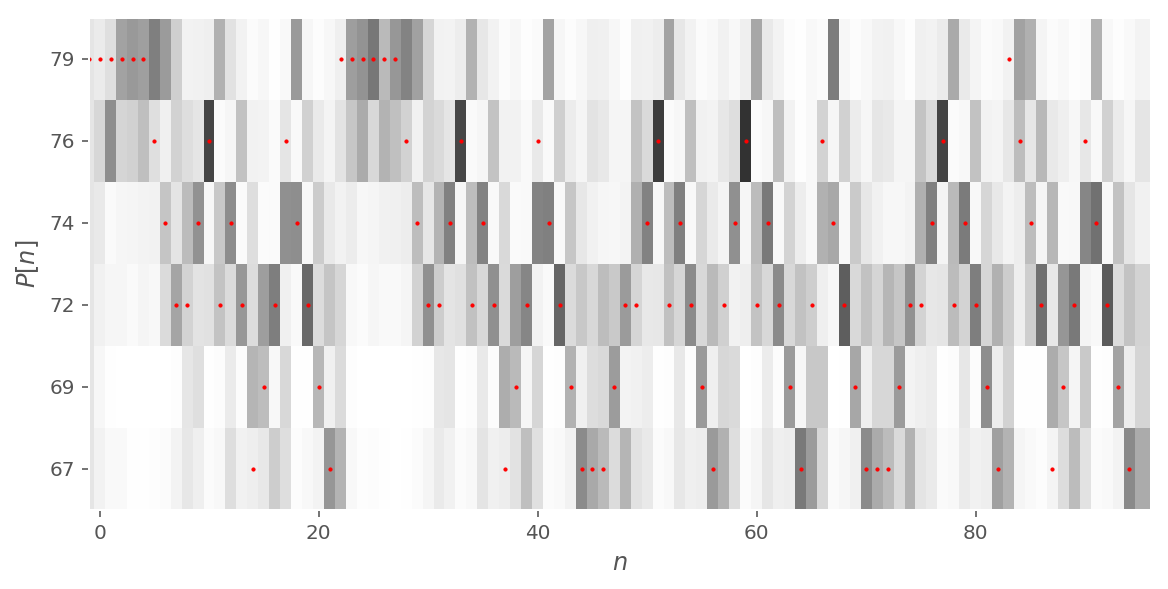

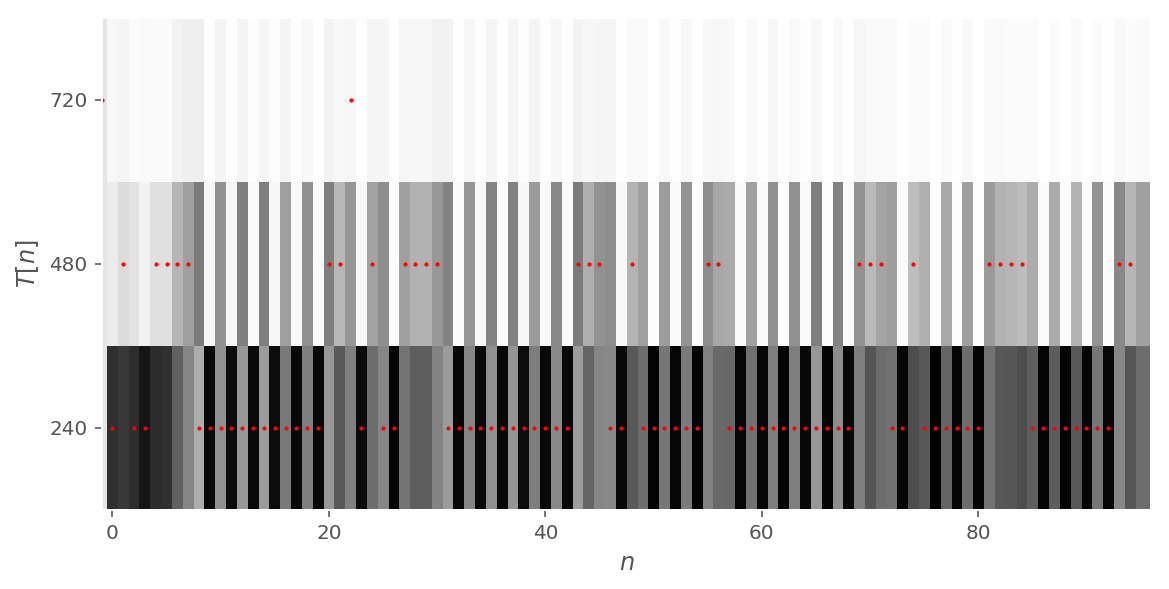

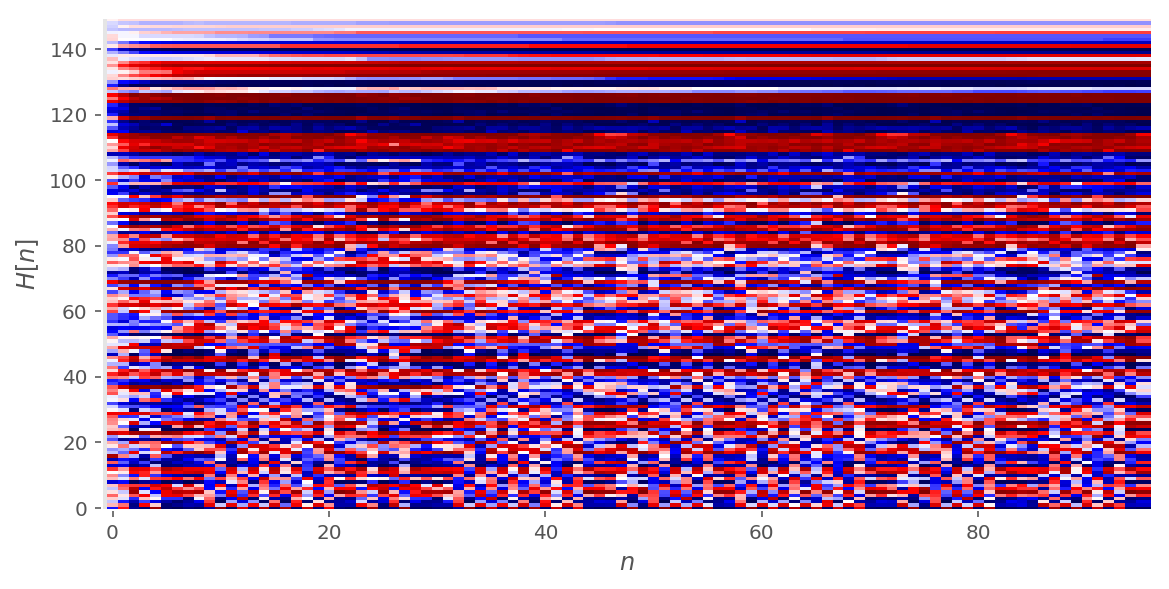

Accuracy: 'P': 18.75%, 'T': 62.5% 

sessiontune27059 SimpleRNNmodel 



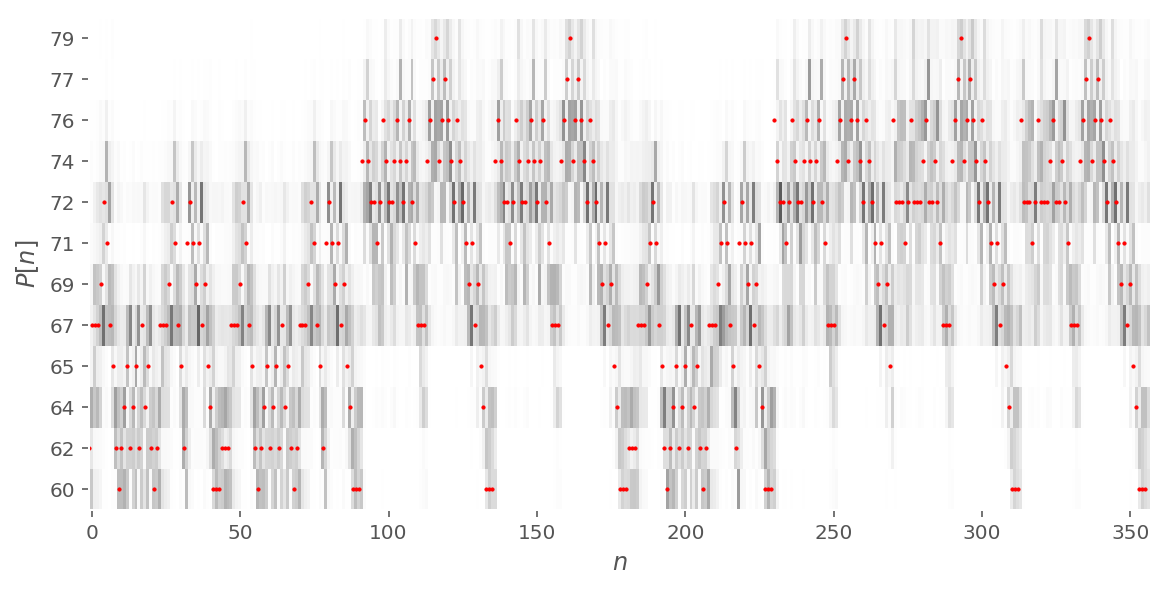

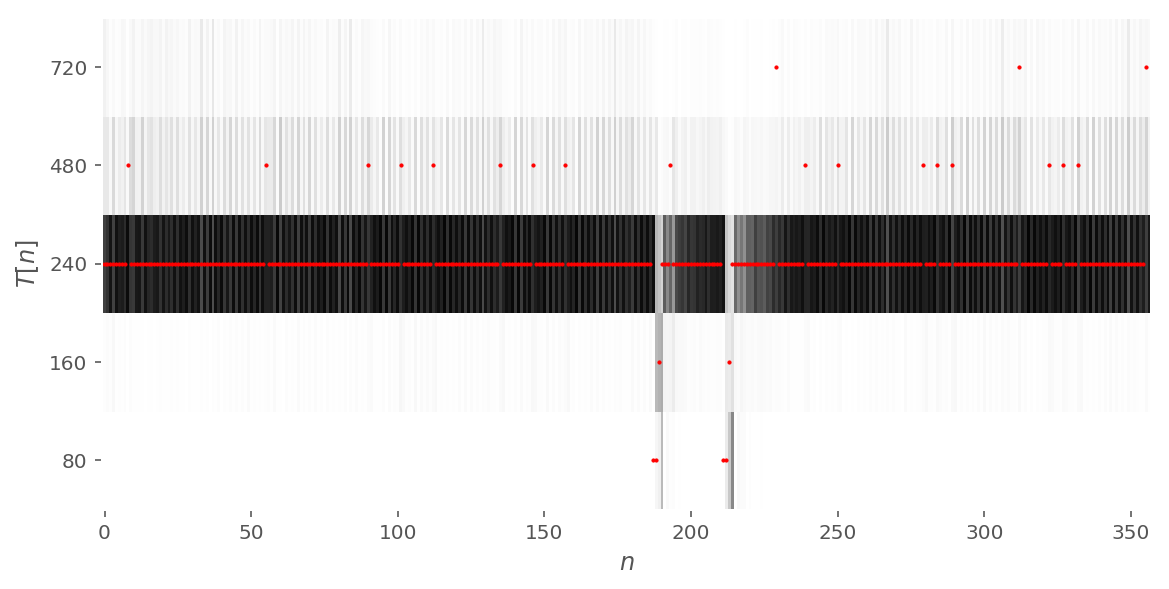

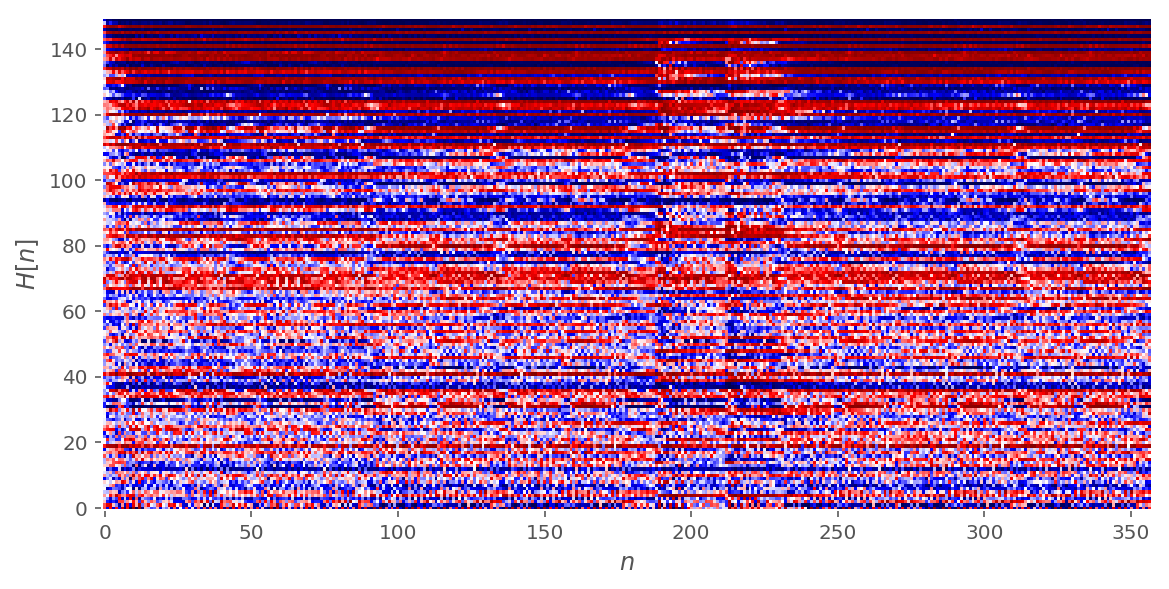

Accuracy: 'P': 8.4%, 'T': 93.0% 

sessiontune27059 GRUmodel 



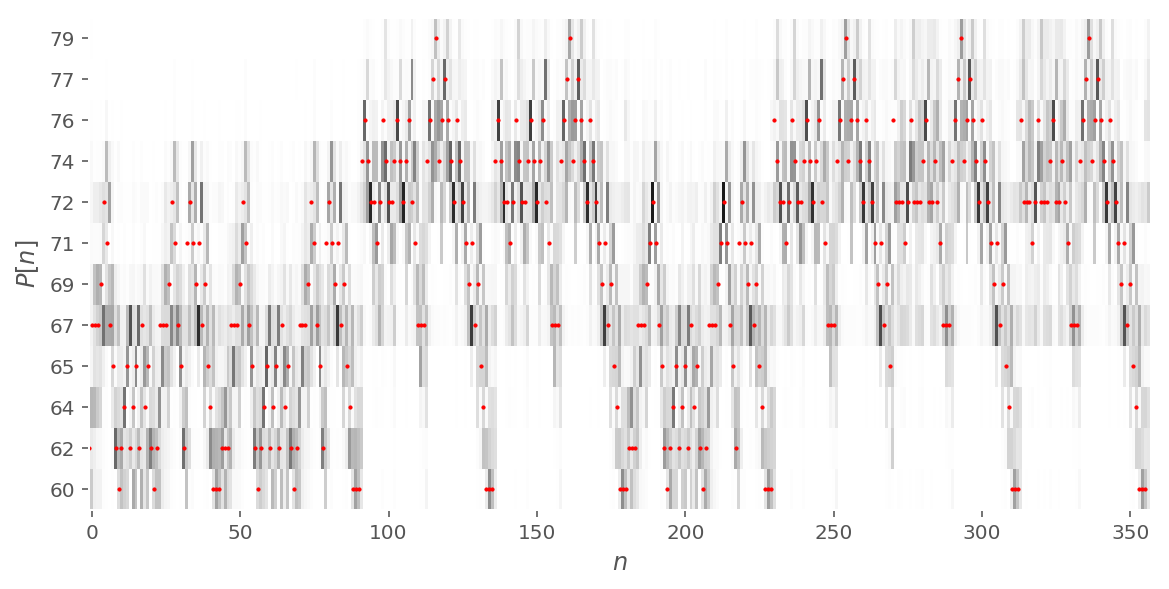

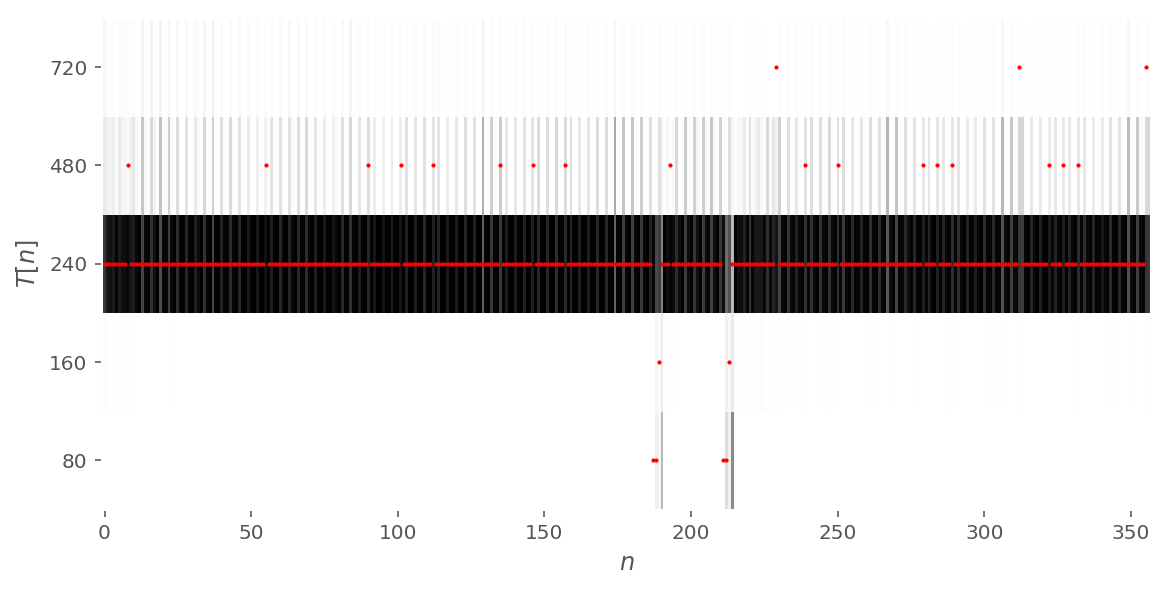

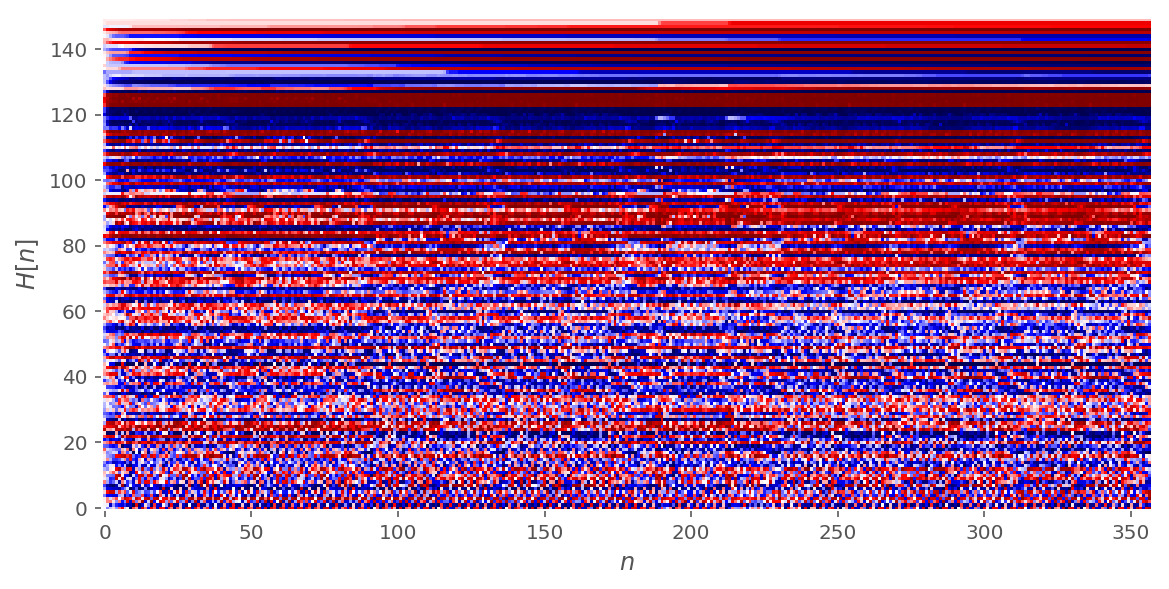

Accuracy: 'P': 12.04%, 'T': 92.72% 

sessiontune7238 SimpleRNNmodel 



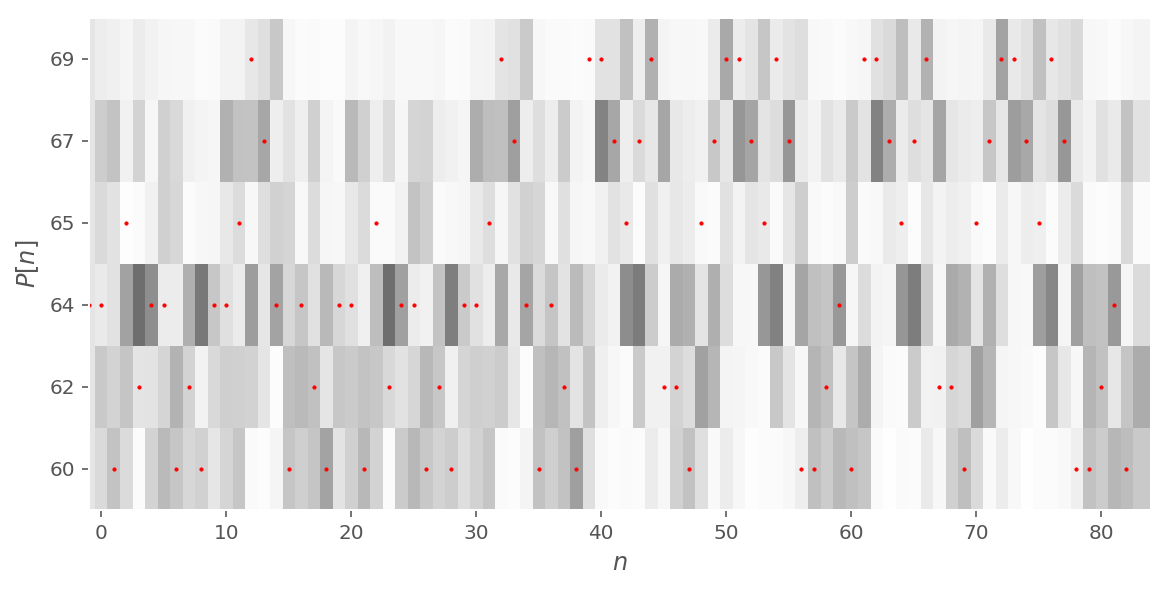

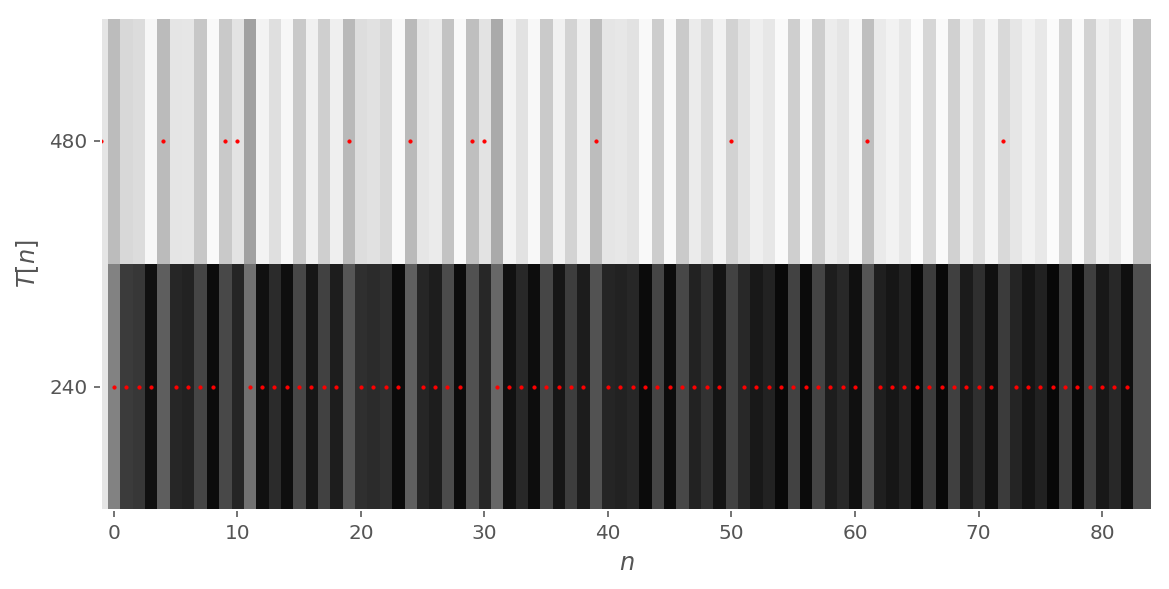

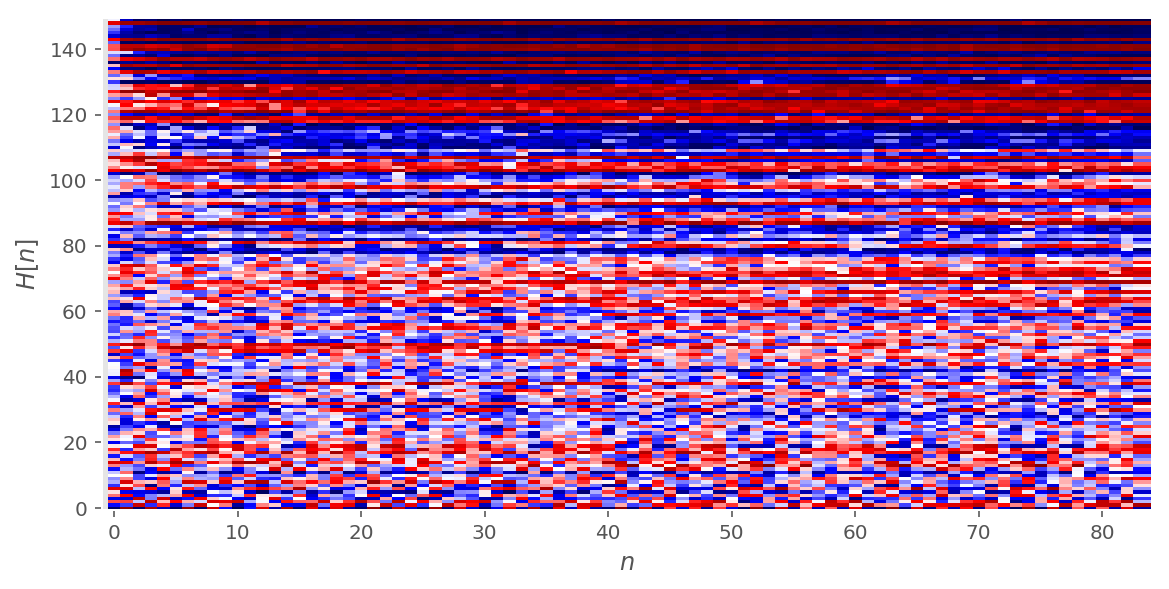

Accuracy: 'P': 0.0%, 'T': 85.71% 

sessiontune7238 GRUmodel 



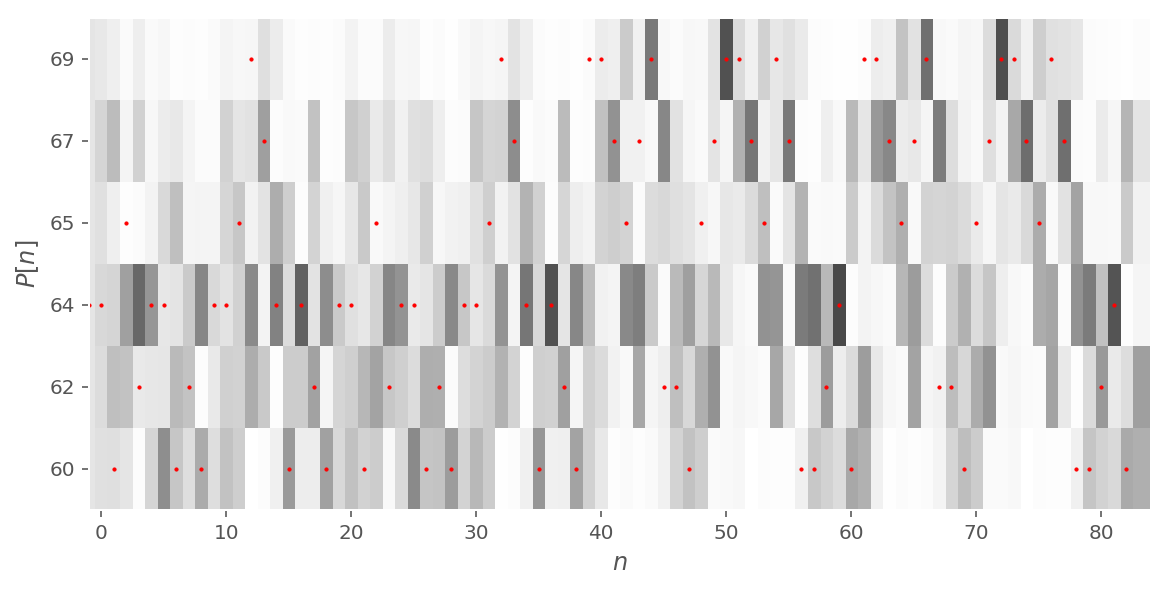

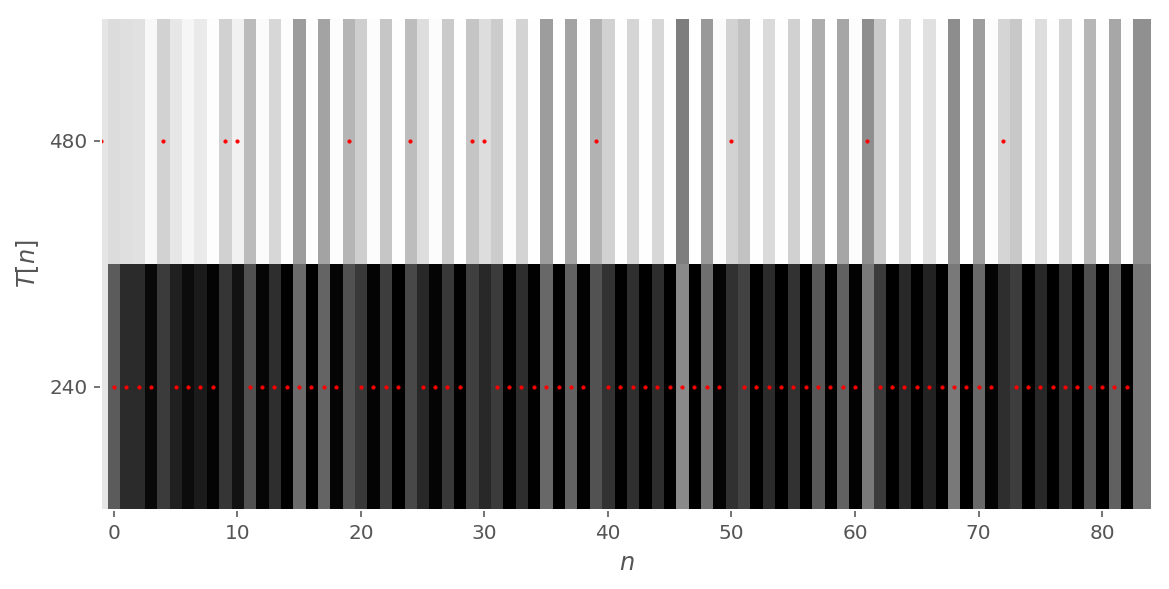

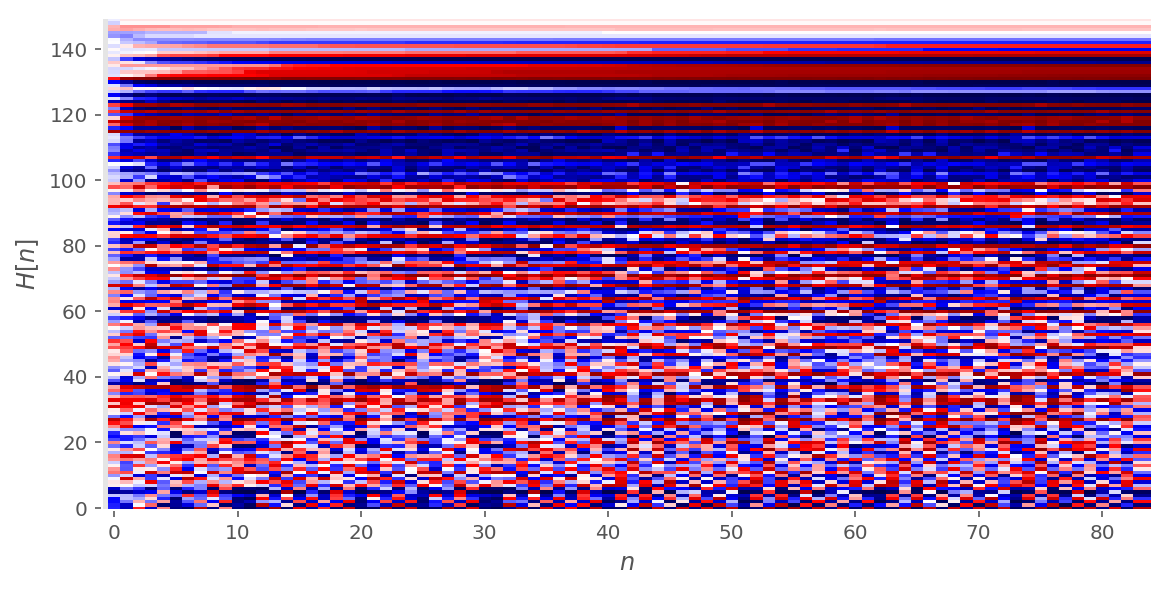

Accuracy: 'P': 1.1900000000000002%, 'T': 84.52% 



In [46]:
for label in np.random.choice(list(dataset.keys()), 4):
    for mod in [[RNNmodel,get_intermediate_RNN, 'SimpleRNNmodel'] , [GRUmodel,get_intermediate_GRU, 'GRUmodel']]:
        dat = {
            'XT': np.expand_dims(dataset[label]['T'][:-1], axis=0),
            'XP': np.expand_dims(dataset[label]['P'][:-1], axis=0)
        }

        pred = mod[0].predict(dat, batch_size=ml-1)
        pred_2 = mod[1]([dat['XT'], dat['XP']])

        t = pred[0].reshape((ml-1, len(dictionary['T'])))
        p = pred[1].reshape((ml-1, len(dictionary['P'])))
        
        H = pred_2[0].reshape((ml-1, 150))

        accu_p = get_accuracy(p, 'P')
        accu_t = get_accuracy(t, 'T')
        print(label, mod[2], '\n')
        plotMelody(dataset[label]['P'], dataset[label]['T'], dictionary, PrP=p, PrT=t, H=H)
        print("Accuracy: 'P': {}%, 'T': {}% \n".format(accu_p, accu_t))

**CHANGES IN ACTIVATION**

In [47]:
def comp_diff(P, T, H):
    """
    Compute difference between two consecutive timesteps along the hidden units. 
    """
    P = np.asarray(P)
    T = np.asarray(T)
    
    xlim = [-1,np.where(P==1)[0][-1]+1]
    activeidxes = np.where(np.sum(P, axis=0)>1.)[0]
    diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
    
    return diff

In [48]:
mean_delta_RNN = {}
mean_delta_GRU = {}

m_d_RNN = {}
m_d_GRU = {}

for label in log_progress(list(dataset.keys()),every=1):
    dat = {
        'XT': np.expand_dims(dataset[label]['T'][:-1], axis=0),
        'XP': np.expand_dims(dataset[label]['P'][:-1], axis=0)
    }
    activation_RNN = get_intermediate_RNN([dat['XT'], dat['XP']])[0].reshape((ml-1, 150))
    activation_GRU = get_intermediate_GRU([dat['XT'], dat['XP']])[0].reshape((ml-1, 150))

    m_d_RNN[label] = comp_diff(dataset[label]['P'], dataset[label]['T'], activation_RNN)
    m_d_GRU[label] = comp_diff(dataset[label]['P'], dataset[label]['T'], activation_GRU)

NameError: name 'activation_RNN' is not defined

In [ ]:
m_RNN = np.asarray(list(m_d_RNN.values()))
ave_RNN = np.mean(m_RNN, axis=0)

m_GRU = np.asarray(list(m_d_GRU.values()))
ave_GRU = np.mean(m_GRU, axis=0)

plt.figure()
plt.hist(ave_RNN, bins=50, color='g', alpha = 1, label = "RNN")
plt.hist(ave_GRU, bins=50, color='r', alpha=0.5, label = "GRU")
plt.legend()
plt.show()

**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.
    
**Answer**: 
It can be seen from the histogram that the number of units with a similar activation value is higher in SimpleRNN than GRU. This can yield to similar probabilities for values surrounding the correct one instead of a clearer unique possible value. As a result, SimpleRNN has less accurate has the "fluctuation" around the correct value is higher than for the GRU model results.
The number of non-active units is higher in the GRU case as the number of parameters is also bigger. 

## Exercise 7: Generation of new melodies
### Description

1. Use your trained best model to generate new melodies. You can do that by starting with a random note, feeding it to your network and sample the output predictions in order to select the next note. Then add this note to your iteratively growing melodies. For your convenience, we provided the `sample` and `writeMIDI` functions. You can use the first in order to perform temperature sampling. The `writeMIDI` function allows you to write a MIDI file from the integer representation.
2. Try different sampling temperatures (e.g. 0.5, 1., 1.5) and observe the effect on your generated melodies.
3. Generate 32 melodies with both the RNN and GRU models
4. Listen to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model). To play in a notebook, use a similar approach as the one shown below assuming you have the files `GRU_1.mid` and `RNN_1.mid` at the same level as this notebook. For your own curiosity, you can also directly listen to the MIDI files with your favorite MIDI player but make sure that we can listen to the 4 extracts directly from this notebook (without rerunning it). If you have trouble achieving that, upload the MIDI files with your submission.
5. (Optional) If you have a big enough computing power, try adding multiple and bigger layers. You could also try to improve your model with different add-ons, e.g. make your model learn when a melody ends, extend it to other datasets, ...
6. (Optional) If you are happy with your results submit a 1 hour long generated MIDI file to the [AI-generated music challenge](https://www.crowdai.org/challenges/ai-generated-music-challenge). 

### Solution

In [ ]:
if not os.path.exists(os.path.dirname("out/")):
    try:
        os.makedirs(os.path.dirname("out/"))
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise

def new_song(ini_p, ini_t, model,label, temperature, generate_song=True):
    xp = np.zeros((ml-1, len(dictionary['P'])))
    xp[0][ini_p] = 1

    xt = np.zeros((ml-1, len(dictionary['T'])))
    xt[0][ini_t] = 1

    song = {
        'xT': [ini_t],
        'xP': [ini_p]
    }
    dat = {
        'XT': np.expand_dims(xt, axis=0),
        'XP': np.expand_dims(xp, axis=0)
    }
    
    for i in range(1, ml-1):
        next_note = model.predict(dat)
        next_note_t = next_note[0][0]
        next_note_p = next_note[1][0]

        t = sample(next_note_t[i-1], temperature)
        dat['XT'][0][i][t] = 1
        song['xT'].append(t)

        p = sample(next_note_p[i-1], temperature)
        dat['XP'][0][i][p] = 1
        song['xP'].append(p)
        
    if generate_song:
        writeMIDI(song['xP'], song['xT'], dictionary, 'out/{}.mid'.format(label))
    return song['xP'], song['xT']

In [ ]:
"""
Generation of 32 melodies for each model.
"""
for i in log_progress(range(32), every=1):
    
    t = randint(0, len(dictionary['T']) - 1)
    p = randint(0, len(dictionary['P']) - 1)
    temp = 0.5
    label1 = 'GRU_{}'.format(i)
    p_gru, t_gru = new_song(p, t, GRUmodel, label1, temp, generate_song=True)
    label2 = 'RNN_{}'.format(i)
    p_rnn, t_rnn = new_song(p, t, RNNmodel, label2, temp, generate_song=True)

In [ ]:
"""
Generation of a melody from both melodies and 3 different sampling temperatures to study the influence of each parameter. 
"""
t = randint(0, len(dictionary['T']) - 1)
p = randint(0, len(dictionary['P']) - 1)
for temp in [0.5, 1, 1.5]:
    print("Sampling temperature: ", temp)
    label1 = 'GRU_{}'.format(i+38)
    p_gru, t_gru = new_song(p, t, GRUmodel, label1, temp, generate_song=False)
    label2 = 'RNN_{}'.format(i+38)
    p_rnn, t_rnn = new_song(p, t, RNNmodel, label2, temp, generate_song=False)

    figure, axarr = plt.subplots(1,2)
    plt.sca(axarr[0])
    figure.set_figheight(5)
    figure.set_figwidth(10)

    axarr[0].hist(p_gru, bins=50, label='Pitches GRU', color='g')
    axarr[0].hist(p_rnn, bins=50, label='Pitches RNN', color='r', alpha=0.5)
    axarr[0].legend()

    plt.sca(axarr[0])
    axarr[1].hist(t_gru, bins=50, label='Durations GRU', color='g')
    axarr[1].hist(t_rnn, bins=50, label='Durations RNN', color='r', alpha=0.5)
    axarr[1].legend()

    plt.show()

In [ ]:
mf = music21.midi.MidiFile()
mf.open('out/GRU_1.mid')
mf.read()
mf.close()
s = music21.midi.translate.midiFileToStream(mf)
print('GRU')
s.show('midi')

In [ ]:
mf = music21.midi.MidiFile()
mf.open('out/RNN_1.mid')
mf.read()
mf.close()
s = music21.midi.translate.midiFileToStream(mf)
print('RNN')
s.show('midi')

**Question**: What is the effect of the sampling temperature on the generated melodies?
    
**Answer**: Lower sampling temperatures yield to lower pitches and durations while higher temperatures result in higher values of both pitch and duration. (See figure 7.1)

**Question**: Are the generated melodies from the RNN model different from the one generated by the GRU model? If yes, what are the main differences?

**Answer**: As it can be seen from the plotted histograms of the generated melodies, the RNN model yields to lower pitches than GRU model as well as lower durations. Nevertheless this difference is not always present. (See figure 7.1)



## Exercise 7.5: (Optional) Improved Model


In [ ]:
GRUmodel_imp = buildModel(dictionary, batch_length=ml-1, activation='GRU', improved=True)
RNNmodel_imp = buildModel(dictionary, batch_length=ml-1, activation='RNN', improved=True)

In [ ]:
historyGRU_imp = GRUmodel_imp.fit(x=xs, y=ys, batch_size=ml-1, epochs=250, verbose=1, callbacks=None, validation_split=0.2)

In [ ]:
historyRNN_imp = RNNmodel_imp.fit(x=xs, y=ys, batch_size=ml-1, epochs=250, verbose=1, callbacks=None, validation_split=0.2)

In [ ]:
save_model(RNNmodel_imp, "RNNmodel_imp")
save_model(GRUmodel_imp, "GRUmodel_imp")

In [ ]:
plotLearningCurves_separated(historyRNN_imp, historyGRU_imp)

In [ ]:
"""
Generation of 32 melodies for each model.
"""
for i in log_progress(range(32), every=1):
    
    t = randint(0, len(dictionary['T']) - 1)
    p = randint(0, len(dictionary['P']) - 1)
    temp = 0.5
    label1 = 'GRU_improved_{}'.format(i)
    p_gru, t_gru = new_song(p, t, GRUmodel, label1, temp, generate_song=True)
    label2 = 'RNN_improved_{}'.format(i)
    p_rnn, t_rnn = new_song(p, t, RNNmodel, label2, temp, generate_song=True)